In [1]:
import os, sys
import pytorch_lightning as pl
import torch
from rdkit import Chem
import numpy as np
import rdkit.Chem.Descriptors
from IPython.display import Image, display, SVG, HTML
from rdkit.Chem import PandasTools
import matplotlib.pyplot as plt
import torch_geometric
from IPython.display import Markdown as md
import dill as pickle
%load_ext tensorboard

In [2]:
if "../../.." not in sys.path:
    sys.path.append("../../..")

In [3]:
DEFAULT_DPI=300
DEFAULT_IMG_PLOT_WIDTH=400
SEED=2
TEST_SMILES='COc1ccccc1[N+](=O)[O-]'
DEFAULT_PATIENCE=10

REDRAW=False
REMODEL=False


if REMODEL:
    REDRAW = True

In [4]:
def plot_true_pred(model,loader,target_file=None):
    true=[]
    pred=[]
    try:
        loader.test_dataloader()
    except:
        loader.setup()
    for i,d in enumerate(loader.test_dataloader()):
        pred.extend(model(d.to(model.device)).detach().cpu().numpy().flatten())
        true.extend(d.y.detach().cpu().numpy().flatten())
        
        
    plt.plot(true,pred,"o")
    if target_file is None:
        plt.show()
    else:
        os.makedirs(os.path.dirname(target_file),exist_ok=True)
        plt.savefig(target_file,dpi=DEFAULT_DPI)
    plt.close()

In [5]:
from IPython.display import clear_output
class ClearCallback(pl.Callback):
    def on_epoch_end(self,*args,**kwargs):
        self.clear()
    
    def clear(self):
        clear_output(wait=True)
    
class StoreMetricsCallback(pl.Callback):
    def __init__(self,live_plot=True,final_save=None,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.data={}
        self.live_plot=live_plot
        self.final_save=final_save
    
    def plot_data(self,save=None):
        plt.figure()
        for label,data in self.data.items():
            plt.plot(data[0],data[1], label=label)
        plt.legend()
        if save:
            plt.savefig(save,dpi=DEFAULT_DPI)
        else:
            plt.show()
        plt.close()
        
    def on_validation_epoch_end(self,trainer, pl_module,*args,**kwargs):
        ep=trainer.current_epoch
        for k,v in trainer.callback_metrics.items():
            if k not in self.data:
                self.data[k]=([],[])
            self.data[k][0].append(ep)
            self.data[k][1].append(v.detach().cpu().numpy())
        if self.live_plot:
            self.plot_data()
        
        #if 'val_loss' in self.data:
        #    display(','.join([str(i) for i in self.data["val_loss"][1]]))
            

    #on_validation_epoch_end = on_epoch_end
    #on_test_epoch_end = on_epoch_end
    #on_train_epoch_end = on_epoch_end
    
    def on_train_end(self,trainer, pl_module):
        self.plot_data(self.final_save)

In [6]:
def plot_category_validation(model,loader,categories,target_file=None, ignore_empty=True):
    true=[]
    pred_correct=[]
    pred_wrong=[]
    for i,d in enumerate(loader.test_dataloader()):
        pred_m=model(d.to(model.device)).detach().cpu().numpy()
        p=pred_m.argmax(1)
        t=d.y.detach().cpu().numpy().argmax(1)
        pred_correct.extend(p[p==t])
        pred_wrong.extend(p[p!=t])
        true.extend(t)
        
        
    #plt.hist(true)
    #plt.hist(pred)
    categories = np.array(categories)
    
   
    labels_true, counts_true = np.unique(true, return_counts=True)
    labels_pred_correct, counts_pred_correct = np.unique(pred_correct, return_counts=True)
    labels_pred_wrong, counts_pred_wrong = np.unique(pred_wrong, return_counts=True)
    
    if ignore_empty:
        all_labels=np.array(list(set(labels_true) | set(labels_pred_correct)| set(labels_pred_wrong)))
        label_list=all_labels.tolist()
        labels_true=np.array([label_list.index(l) for l in labels_true])
        labels_pred_correct=np.array([label_list.index(l) for l in labels_pred_correct])
        labels_pred_wrong=np.array([label_list.index(l) for l in labels_pred_wrong])
    
    plt.bar(labels_true-0.2, counts_true, align='center',width=0.2,label="true")
    plt.bar(labels_pred_correct, counts_pred_correct, align='center',width=0.2,label="correct predicted")
    plt.bar(labels_pred_wrong+0.2, counts_pred_wrong, align='center',width=0.2,label="wrong predicted")
    
    #n, bins, patches = plt.hist([true,pred], len(categories), density=False)
    #print(bins, len(categories))
    x=np.arange(len(categories))
    if ignore_empty:
        x=np.arange(len(all_labels))
        categories = categories[all_labels]
    #print(x,categories)
    plt.xticks(ticks=x,labels=categories, rotation=90, horizontalalignment='left')
    plt.legend()
    plt.tight_layout()
    if target_file is None:
        plt.show()
    else:
        os.makedirs(os.path.dirname(target_file),exist_ok=True)
        plt.savefig(target_file,dpi=DEFAULT_DPI)
    plt.close()

#plot_category_validation(model,loader,atom_hybridization_one_hot.describe_features())

In [7]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import dill as pickle

def default_model_run(model_name,model,loader,force_run=False,detect_lr=True,show_tb=True,
                      train=True,save=True,test=True,live_plot=True,max_epochs=1000,min_epochs=1,
                      ignore_load_error=False,force_test_data_reload=False,early_stopping=True,
                      categories=None,
                     ):
    
    data={"files":{}}
    data["model_name"]=model_name
    data["files"]["model_dir"]=os.path.join("models",data["model_name"])

    data["files"]["logdir"]=os.path.join(data["files"]["model_dir"],"logs")
    data["files"]["tb_logdir"]=os.path.join(data["files"]["logdir"],"tensorboard")
    
    data["files"]["plot_dir"]=os.path.join(data["files"]["model_dir"],"plots")
    
    os.makedirs(data["files"]["plot_dir"],exist_ok=True)
    data["files"]["true_pred_plt"]=os.path.join(data["files"]["plot_dir"],"tvp.png")
    data["files"]["lr_optim_plot"]=os.path.join(data["files"]["plot_dir"],"lrp.png")
    data["files"]["metrics_plot"]=os.path.join(data["files"]["plot_dir"],"metrics.png")
    data["files"]["cat_plot"]=os.path.join(data["files"]["plot_dir"],"cat_validation.png")
    
    data["files"]["model_checkpoint"]=os.path.join(data["files"]["model_dir"],"model.ckpt")
    data["files"]["test_data_file"]=os.path.join(data["files"]["model_dir"],"test_data.pickle")
    data["files"]["test_batch_file"]=os.path.join(data["files"]["model_dir"],"test_batch.pickle")
    
    
    
    if not force_run :
        try:
            model = model.__class__.load_from_checkpoint(data["files"]["model_checkpoint"],
                                                         map_location=lambda storage, location: storage)
        except:
            if ignore_load_error:
                pass
            else:
                force_run=True
        try:
            test_data = pickle.load( open( data["files"]["test_data_file"], "rb" ) )
            test_batch = pickle.load( open( data["files"]["test_batch_file"], "rb" ) )
        except:
            force_run=True
    
    if force_test_data_reload or force_run:
        test_data=find_test_data(loader)
        test_batch=iter(torch_geometric.data.DataLoader([test_data])).next()
        pickle.dump( test_data, open( data["files"]["test_data_file"], "wb" ) )
        pickle.dump( test_batch, open( data["files"]["test_batch_file"], "wb" ) )
        
    if force_run:
        
        try:
            loader.test_dataloader()
        except:
            loader.setup()
        
        if detect_lr:
            lr_trainer = pl.Trainer()
            lr_finder = lr_trainer.tuner.lr_find(model,train_dataloader=loader.train_dataloader(),max_lr=10**2)
            fig = lr_finder.plot(suggest=True)
            
            plt.savefig(data["files"]["lr_optim_plot"],dpi=DEFAULT_DPI)
            plt.close()
            
            model.lr = lr_finder.suggestion()
            print("set lr to",model.lr)
    
        if train or test:
            clear_cb=ClearCallback()
            tb_logger = TensorBoardLogger(data["files"]["tb_logdir"])
            checkpoint_callback = ModelCheckpoint(monitor='val_loss')
            metrics_cb = StoreMetricsCallback(live_plot=live_plot,
                                 final_save=data["files"]["metrics_plot"],
                                 )
            early_stop_cb = EarlyStopping(
                        monitor='val_loss',patience=DEFAULT_PATIENCE,
                min_delta=10**(-4),
            )
            
            cb=[]
            
            if early_stopping:
                cb=[early_stop_cb]
            
            cb.extend([
                checkpoint_callback,
                clear_cb,
                metrics_cb,
               ])
            
            trainer = pl.Trainer(max_epochs=max_epochs,
                                 gpus=torch.cuda.device_count(),
                                 callbacks=cb,
                                 logger=tb_logger,
                                 terminate_on_nan=True,
                                 min_epochs=min_epochs,
                                )

        if train:
            trainer.fit(model,loader)
            model = model.__class__.load_from_checkpoint(checkpoint_callback.best_model_path)
            
        if test:
            trainer.test(model=model,ckpt_path=None)
            
        if save:
            trainer.save_checkpoint(data["files"]["model_checkpoint"])
        
        
    
    model.to('cpu')
    if REDRAW:
        plot_true_pred(model,loader,target_file=data["files"]["true_pred_plt"])
        if categories:
            plot_category_validation(model,loader,categories,target_file=data["files"]["cat_plot"])
    
    if os.path.exists(data["files"]["lr_optim_plot"]):
        display(Image(data["files"]["lr_optim_plot"], width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(data["files"]["metrics_plot"]):
        display(Image(data["files"]["metrics_plot"], width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(data["files"]["true_pred_plt"]):
        display(Image(data["files"]["true_pred_plt"], width=DEFAULT_IMG_PLOT_WIDTH))
    if os.path.exists(data["files"]["cat_plot"]):
        display(Image(data["files"]["cat_plot"], width=DEFAULT_IMG_PLOT_WIDTH))
    
    
    data["test_data"]=test_data
    data["test_batch"]=test_batch
         
    try:
        data["trainer"]=trainer
    except:
        pass
    return model,data

In [8]:
def find_test_data(loader,smiles=None):
    if smiles is None:
        smiles = TEST_SMILES
    try:
        loader.test_dataloader()
    except:
        loader.setup()
    sdt=0
    for subloader in [loader.test_dataloader(),loader.val_dataloader(),loader.train_dataloader()]:
        for i,d in enumerate(subloader):
            for sd in d.to_data_list():
                if sd.string_data_titles[0][sdt] != "index":
                    sdt=sd.string_data_titles[0].index("smiles")
                if smiles == sd.string_data[0][sdt]:
                    return sd
    raise ValueError()

                

In [9]:
import networkx as nx
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    """Normalise the colorbar."""
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    
def plot_fcnn(layer_sizes,weights=None, biases=False,show_bar=False,input_labels=None,weight_position=None,
              round_weights=2,edge_width=1,save=None,show=None,hide_loose=False,cmap=plt.cm.coolwarm,nodes_cmap=plt.cm.coolwarm,
             input_array=None
             ):
    g=nx.Graph()
    pos={}
    w=0
    if weights is not None:
        for i in range(len(weights)):
            assert weights[i].shape[0] == layer_sizes[i+1],(weights[i].shape[0], layer_sizes[i+1])
            assert weights[i].shape[1] == layer_sizes[i],(weights[i].shape[1], layer_sizes[i])
            weights[i]=np.round(weights[i],round_weights)
        
        
    for l,n in enumerate(layer_sizes):
        for i in range(n):
            node="{}_{}".format(l,i)
            node_d={"layer":l,
                   "layer_pos":i,
                    "show":True
                   }
            
            if input_labels is not None:
                if len(input_labels)>len(g):
                    node_d["label"]=input_labels[len(g)]
            g.add_node(node,**node_d)
            #pos[node]=(l*50,-(i-n/2)*10)
            if l>0:
                for j in range(layer_sizes[l-1]):
                    pnode="{}_{}".format(l-1,j)
                    ed={"show":True}
                    if weights is not None:
                        #display(weights[l-1])
                        #display(l,n,j,i)
                        ed["w"]=weights[l-1][i][j]
                        if hide_loose and ed["w"]==0:
                            ed["show"]=False
                        w+=1
                    g.add_edge(pnode,node,**ed)
    
    
    
    if hide_loose:
        for node,nd in g.nodes(data=True):
            if g.edges(node) == 0 or all([not g.get_edge_data(*e)["show"] for e in g.edges(node)]):
                g.nodes[node]["show"]=False
            
    nodes_kwargs={}    
    if input_array is not None and weights is not None:
        node_values=[input_array[:layer_sizes[0]]]
        for i,w in enumerate(weights):
            node_values.append(np.dot(w,node_values[i]))
        
        for node,nd in g.nodes(data=True):
            g.nodes[node]["value"]=node_values[nd["layer"]][nd["layer_pos"]]
            
        vmin = min([w.min() for w in node_values])
        vmax= max([w.max() for w in node_values])
        sm_nodes = plt.cm.ScalarMappable(cmap=nodes_cmap, norm=MidpointNormalize(vmin, vmax, 0.))
        
        nodes_kwargs["node_color"]=[sm_nodes.to_rgba(nd["value"]) for n,nd in g.nodes(data=True) if nd["show"]]
        
    
    #reposition
    layer_pos={ln:0 for ln in range(l+1)}
    showing_layer_size=[0]*len(layer_sizes)
    for node,nd in g.nodes(data=True):
        if nd["show"]:
            showing_layer_size[nd["layer"]]+=1
            
    for node,nd in g.nodes(data=True):
        if nd["show"]:
            l=nd["layer"]
            pos[node]=(l*50,-((layer_pos[l]-showing_layer_size[l]/2)*10))
            layer_pos[l]+=1
        #else:
        #    pos[node]=(0,0)
    
    while showing_layer_size[-1]==0:
        showing_layer_size.pop(-1)

    
    fs=(2*(len(showing_layer_size)+1),1+max(showing_layer_size)/3)

    
    if weights is not None:
        vmin = min([w.min() for w in weights])
        vmax= max([w.max() for w in weights])
        sm_edges = plt.cm.ScalarMappable(cmap=cmap, norm=MidpointNormalize(vmin, vmax, 0.))
    
    fig = plt.figure(figsize=fs)
    nodes = nx.draw_networkx_nodes(
        g, pos,nodelist=[n for  n,nd in g.nodes(data=True) if nd["show"]],
        **nodes_kwargs
        )
    
    max_end_width=0
    if input_labels:
        for i,(node,data) in enumerate(g.nodes(data=True)):
            if data["show"] and "label" in data and data["label"]:
                if data["layer"]==0:
                    x,y=pos[node]
                    x=x-6
                    plt.text(x,y,s=data["label"], bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='right',verticalalignment="center_baseline")
                elif data["layer"]==len(layer_sizes)-1:
                    x,y=pos[node]
                    x=x+6
                    t=plt.text(x,y,s=data["label"], bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='left',verticalalignment="center_baseline")
                    r = fig.canvas.get_renderer()
                    bb = t.get_window_extent(renderer=r)
                    max_end_width = max(max_end_width,bb.width)
                else:
                    x,y=pos[node]
                    plt.text(x,y,s=data["label"], bbox=dict(facecolor='white', alpha=0.5),horizontalalignment='center',verticalalignment="center_baseline")
                    
    ed={'width':edge_width,
       'edgelist':[(n1,n2) for n1,n2,v in g.edges(data=True) if v["show"]],
       }
    if weights is not None:
        ed={**ed,**dict(edge_cmap= cmap,
                edge_color=[sm_edges.to_rgba(v["w"]) for n1,n2,v in g.edges(data=True) if v["show"]]
               )
           }
        
        if weight_position is not None:
            def draw_networkx_edge_labels(edge_labels,label_pos):
                nodes = nx.draw_networkx_edge_labels(
                            g, pos,
                            edge_labels=edge_labels,
                            rotate=False,
                            label_pos=label_pos,
                            norm=sm_edges,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
                        )
                
            if isinstance(weight_position,(float,int)):
                edge_labels={(n1,n2):v["w"] for n1,n2,v in g.edges(data=True) if v["show"]}
                label_pos = 1-weight_position
                draw_networkx_edge_labels(edge_labels,label_pos)
            else:
                assert len(weight_position) == len(layer_sizes)-1
                for i,wp in enumerate(weight_position):
                    if wp is None:
                        continue
                    if isinstance(wp,(float,int)):
                        edge_labels={}
                        for n1,n2,v in g.edges(data=True):
                            if n1.startswith("{}_".format(i)) and v["show"]:
                                edge_labels[(n1,n2)]=v["w"]
                        nodes = draw_networkx_edge_labels(
                            edge_labels=edge_labels,
                            label_pos=1-wp,
                        )
                        
        if show_bar:
            bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            
            plt.colorbar(sm_edges,pad = 0.1+max_end_width/(bbox.width*fig.dpi))
            if "node_color" in nodes_kwargs:
                plt.colorbar(sm_nodes,pad = 0.1+max_end_width/(bbox.width*fig.dpi))
    
    edges = nx.draw_networkx_edges(g, pos,**ed)

    #plt.tight_layout
    plt.axis('off')
    if save is not None:
        os.makedirs(os.path.dirname(save),exist_ok=True)
        plt.savefig(save,dpi=DEFAULT_DPI)
    if show is None:
        if save is not None:
            show=False
        else:
            show=True
    cut = 1.15
    xmax= max(xx for xx,yy in pos.values())+10
    ymax= max(yy for xx,yy in pos.values())+10
    xmin= min(xx for xx,yy in pos.values())-10
    ymin= min(yy for xx,yy in pos.values())-10
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    #fig.tight_layout()
    if show:
        plt.show()
    plt.close()

#w=np.random.random(8)-0.4
#w[np.abs(w)<0.3]=0
#plot_fcnn([3,2,1],w,
#          input_labels=["input_{}".format(i) for i in range(20)]+\
#          ["center_{}".format(i) for i in range(5)]+\
#          ["output_{}".format(i) for i in range(1)],
#          weight_position=[None,0.2],edge_width=2,
#         hide_loose=True,
#          show_bar=True
#)

w=np.random.random(130)-0.4
w[np.abs(w)<0.3]=0

a,b,c=25,5,1
wab,wbc=np.random.random(a*b).reshape(b,a)-0.6,np.random.random(b*c).reshape(c,b)-0.6
wab[np.abs(wab)<0.3]=0
wbc[np.abs(wbc)<0.3]=0


#display(np.dot(np.arange(a),wab))

#plot_fcnn([a,b,c],[wab,wbc],
#          input_labels=["input_{}".format(i) for i in range(a)]+\
#         ["center_{}".format(i) for i in range(b)]+\
#          ["output_{}".format(i) for i in range(c)],
#          weight_position=[None,0.2],edge_width=2,
##         hide_loose=True,
#          show_bar=True,
#          input_array=np.arange(a+1)
#         )

In [10]:
#first a blank mol dataset
#from molNet.dataloader.datasets import DelaneySolubility
#dataset=DelaneySolubility().df
from molNet.dataloader.molecule_loader import MoleculeGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot_from_set,atom_hybridization_one_hot
import pandas as pd
dataset = pd.read_csv("list_chemicals-2020-12-05-21-46-06.tsv",sep="\t")

TEST_SMILES=Chem.MolToSmiles(Chem.MolFromSmiles(TEST_SMILES))
dataset = dataset.append({
    'SMILES':"C",
    'PREFERRED_NAME':"Methane"
},ignore_index=True)


from rdkit.Chem.rdmolops import ReplaceSubstructs
patt1 = Chem.MolFromSmarts('[1H]')
patt2 = Chem.MolFromSmarts('[2H]')
repl = Chem.MolFromSmarts('[H]')


has_fags=dataset.index[dataset["SMILES"].apply(lambda x: "*" in x)]
dataset.drop(has_fags,inplace=True)

dataset["rd_mol"] = dataset['SMILES'].apply(lambda s:Chem.MolFromSmiles(s))

no_mols = dataset.index[~dataset["rd_mol"].apply(lambda x: isinstance(x,Chem.Mol))]
dataset.drop(no_mols,inplace=True)



dataset["rd_mol"] = dataset['rd_mol'].apply(lambda mol: 
                                           ReplaceSubstructs(ReplaceSubstructs(Chem.AddHs(mol),
                                                             patt1,repl,replaceAll=True)[0],patt2,repl,replaceAll=True)[0])

dataset["SMILES"] = dataset['rd_mol'].apply(lambda s: Chem.MolToSmiles(s))
dataset["molar_mass"] = dataset['rd_mol'].apply(lambda mol: Chem.Descriptors.MolWt(mol))
dataset = dataset.rename({'PREFERRED_NAME':'name'},axis=1)


loader = MoleculeGraphFromDfLoader(
    dataset,
    smiles_column='SMILES',
    batch_size=32,
    split=1,
    shuffle=False,
)
try:
    loader.train_dataloader()
except:
    loader.setup()
s=0
mol_graphs=[]
for d in loader.train_dataloader():
    mol_graphs.extend(d)

dataset["pre_graphs"]=mol_graphs    
    


dataset["hybridization"] = dataset['pre_graphs'].apply(lambda mg: np.array([atom_hybridization_one_hot(a) for a in mg.mol.GetAtoms()]))
#dataset["hybridization_t"] = dataset['hybridization'].apply(lambda h: h.T)
#for i,s in enumerate(atom_hybridization_one_hot.describe_features()):
#    dataset[s]=dataset["hybridization"].apply(lambda h:h[:,i])
    
c_atom_symbol_featurizer = atom_symbol_one_hot_from_set(dataset["rd_mol"],only_mass=True)
dataset
#c_atom_symbol_featurizer.describe_features()
#for i,data in dataset.iterrows():
#    for atom in data["rd_mol"].GetAtoms():
#        if atom.GetSymbol()=="*":
#            display(data["rd_mol"])
#            display(data)
#            break

,DTXSID,name,CASRN,INCHIKEY,IUPAC_NAME,SMILES,INCHI_STRING,MOLECULAR_FORMULA,AVERAGE_MASS,MONOISOTOPIC_MASS,DATA_SOURCES,NUMBER_OF_PUBMED_ARTICLES,PUBCHEM_DATA_SOURCES,CPDAT_COUNT,rd_mol,molar_mass,pre_graphs,hybridization
0,DTXSID7020009,Acetonitrile,75-05-8,WEVYAHXRMPXWCK-UHFFFAOYSA-N,Acetonitrile,[H]C([H])([H])C#N,InChI=1S/C2H3N/c1-2-3/h1H3,C2H3N,41.053,41.026549101,165.0,3174.0,1110,318,"<img data-content=""rdkit/molecule"" src=""data:i...",41.053,"(0, 1, 2, 3, 4, 5)","[[False, False, False, False, False, True, Fal..."
1,DTXSID5020023,Acrolein,107-02-8,HGINCPLSRVDWNT-UHFFFAOYSA-N,Prop-2-enal,[H]C(=O)C([H])=C([H])[H],"InChI=1S/C3H4O/c1-2-3-4/h2-3H,1H2",C3H4O,56.064,56.026214749,189.0,2468.0,139,30,"<img data-content=""rdkit/molecule"" src=""data:i...",56.064,"(0, 1, 2, 3, 4, 5, 6, 7)","[[False, False, False, False, False, True, Fal..."
2,DTXSID0020024,Acrolein diethylacetal,3054-95-3,MCIPQLOKVXSHTD-UHFFFAOYSA-N,"3,3-Diethoxyprop-1-ene",[H]C([H])=C([H])C([H])(OC([H])([H])C([H])([H])...,"InChI=1S/C7H14O2/c1-4-7(8-5-2)9-6-3/h4,7H,1,5-...",C7H14O2,130.187,130.099379691,45.0,1.0,100,-,"<img data-content=""rdkit/molecule"" src=""data:i...",130.187,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3,DTXSID5020029,Acrylonitrile,107-13-1,NLHHRLWOUZZQLW-UHFFFAOYSA-N,Prop-2-enenitrile,[H]C([H])=C([H])C#N,"InChI=1S/C3H3N/c1-2-3-4/h2H,1H2",C3H3N,53.064,53.026549101,195.0,1092.0,168,582,"<img data-content=""rdkit/molecule"" src=""data:i...",53.064,"(0, 1, 2, 3, 4, 5, 6)","[[False, False, False, False, False, True, Fal..."
4,DTXSID8020044,Allyl alcohol,107-18-6,XXROGKLTLUQVRX-UHFFFAOYSA-N,Prop-2-en-1-ol,[H]OC([H])([H])C([H])=C([H])[H],"InChI=1S/C3H6O/c1-2-3-4/h2,4H,1,3H2",C3H6O,58.08,58.041864813,153.0,627.0,152,2,"<img data-content=""rdkit/molecule"" src=""data:i...",58.080,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[[False, False, False, False, False, True, Fal..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3851,DTXSID30996806,(6-Methylheptan-2-yl)hydrazine,7535-34-4,WAYKZORTCXXXDO-UHFFFAOYNA-N,(6-Methylheptan-2-yl)hydrazine,[H]N([H])N([H])C([H])(C([H])([H])[H])C([H])([H...,"InChI=1/C8H20N2/c1-7(2)5-4-6-8(3)10-9/h7-8,10H...",C8H20N2,144.262,144.162648652,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",144.262,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3852,DTXSID10998848,2-Chlorooxirane,7763-77-1,WBNCHVFLFSFIGK-UHFFFAOYNA-N,2-Chlorooxirane,[H]C1([H])OC1([H])Cl,"InChI=1/C2H3ClO/c3-2-1-4-2/h2H,1H2",C2H3ClO,78.5,77.9872424,6.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",78.498,"(0, 1, 2, 3, 4, 5, 6)","[[False, False, False, False, False, True, Fal..."
3853,DTXSID20999144,2-[(Butan-2-yl)oxy]ethan-1-ol,7795-91-7,HUWFDQSAXOIUNP-UHFFFAOYNA-N,2-[(Butan-2-yl)oxy]ethan-1-ol,[H]OC([H])([H])C([H])([H])OC([H])(C([H])([H])[...,"InChI=1/C6H14O2/c1-3-6(2)8-5-4-7/h6-7H,3-5H2,1...",C6H14O2,118.176,118.099379691,11.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",118.176,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."
3854,DTXSID70999775,2-Methyl-1-[(propan-2-yl)oxy]propane,78448-33-6,HIIBZFKVMXEQMR-UHFFFAOYSA-N,2-Methyl-1-[(propan-2-yl)oxy]propane,[H]C([H])([H])C([H])(OC([H])([H])C([H])(C([H])...,"InChI=1S/C7H16O/c1-6(2)5-8-7(3)4/h6-7H,5H2,1-4H3",C7H16O,116.204,116.120115135,3.0,-,-,-,"<img data-content=""rdkit/molecule"" src=""data:i...",116.204,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[False, False, False, False, False, True, Fal..."


In [11]:
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds, CalcExactMolWt, CalcNumLipinskiHBD, CalcNumRings, \
    CalcNumLipinskiHBA, CalcNumHBA, CalcNumHBD, CalcNumAromaticRings, CalcNumSaturatedRings, CalcNumHeterocycles, \
    CalcNumAromaticHeterocycles, CalcNumAromaticCarbocycles, CalcNumSaturatedHeterocycles, CalcNumSaturatedCarbocycles, \
    CalcNumAliphaticRings, CalcNumAliphaticHeterocycles, CalcNumAliphaticCarbocycles, CalcNumHeteroatoms, \
    CalcNumAmideBonds, CalcFractionCSP3, CalcLabuteASA, CalcTPSA, CalcChi0v, CalcChi1v, CalcChi2v, CalcChi3v, CalcChi4v, \
    CalcChi0n, CalcChi1n, CalcChi2n, CalcChi3n, CalcChi4n, CalcHallKierAlpha, CalcKappa1, CalcKappa2, CalcKappa3, \
    CalcNumSpiroAtoms, CalcNumBridgeheadAtoms, CalcNumAtomStereoCenters, CalcNumUnspecifiedAtomStereoCenters, CalcPBF, \
    CalcNPR1, CalcNPR2, CalcPMI1, CalcPMI2, CalcPMI3, CalcRadiusOfGyration, CalcInertialShapeFactor, CalcEccentricity, \
    CalcAsphericity, CalcSpherocityIndex, CalcCrippenDescriptors, GetUSR, GetUSRCAT, SlogP_VSA_, SMR_VSA_, PEOE_VSA_, \
    CalcWHIM, CalcGETAWAY, CalcRDF, CalcMORSE, CalcAUTOCORR3D, CalcAUTOCORR2D
sdf=dataset.copy()

sdf=sdf[sdf.rd_mol.apply(lambda mol: CalcNumAromaticRings(mol)>0)]
patern=Chem.MolFromSmarts('[N+]([O-])=O')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
patern=Chem.MolFromSmarts('cOC')
sdf=sdf[sdf.rd_mol.apply(lambda mol: mol.HasSubstructMatch(patern))]
m =sdf.iloc[0].rd_mol

TEST_SMILES=Chem.MolToSmiles(sdf.sort_values("molar_mass",axis=0).rd_mol.iloc[0])

First we start with a simple example by predicting the molar masses of random molecules (**maybe library for creating pseudo random molecules**). As a featurization the mass of each individual atom was used. As a resultto get the molar mass of each respective molecule all features (individual atomic masses) have to be added. 
The process to sum all features together is basically one possibillity for a pooling operation. pooling is usally done at the end of a graph convolution to bring an arbitary shaped graph to an fixed size vecor.
Basic pooling operation are operations to calculate scalar parameters like location parameter (*e.g*.minimum, maximm average) or the sum over every dimension of the final features of the graph. This results in a vector of a size equal to the number if final features, which is a fixed hyperparameter for the models.
$$f=\Theta(f_0,f_1,...f_{N})$$

If we just perform a simple sum pooling over the inital graph features without any graph convolution or what so ever, there are no trainable parameters in the model and thus training is not necessary (nor possible):

In [12]:
from molNet.nn.models.graph_convolution import PoolSum
from molNet.dataloader.molecule_loader import PytorchGeomMolGraphFromGeneratorLoader, PytorchGeomMolGraphGenerator, PytorchGeomMolGraphFromDfLoader
from molNet.featurizer.atom_featurizer import atom_mass

class SimpleSumAtomMassesModel(pl.LightningModule):
    def __init__(self,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling =PoolSum()

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        return feats*100

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)
        
    def to_graphviz(self,batch=None,reduced=False):
        if batch is None:
            ip=10
        else:
            batch.to_data_list()[0].
        
            
        
    
# no parameter and thus no training necessary
model = SimpleSumAtomMassesModel()


loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                         y_properties=["molar_mass"],
                                         #seed=SEED,
                                         to_graph_params={"atom_featurizer":atom_mass,"with_mol_graph":True},
                                        batch_size=32
                                        )

model,data = default_model_run(
    "SimpleSumAtomMassesModel",
    model,
    loader,
    force_run=REMODEL or True,
    detect_lr=False,
    show_tb=False,
    train=False,
    save=False,
    ignore_load_error=not REMODEL
)

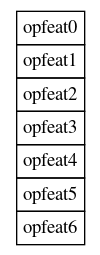

In [528]:
def poolsum_to_graphviz(self,name="PoolSum",input_shape=(6,5),reduced=False):
    g = Digraph(name,node_attr={'shape': 'record'})
    g.attr(rankdir='LR', size='8,5')
    g.attr(compound='true')
    #g.attr(splines = "false" )
    
    inputs="{{"+"|".join(["<ip{{}}f{}>ip{{}}f{}".format(i,i) for i in range(input_shape[1])])+"}}"
    
    g.node("{}_op_feats".format(name),
              label="|".join(["<op_{}> opfeat{} ".format(x,x) for x in range(input_shape[1])])
              )
    
    g.node("{}_ip".format(name),
              label="|".join([
                  inputs.format(*([x]*input_shape[1]*2)) 
                  for x in range(input_shape[0])])
              )    
    
    for i in range(input_shape[1]):
        sumer="{}_sum{}".format(name,i)
        g.node(sumer,
              label="+",shape='circle'
              )
        
        for x in range(input_shape[0]):
            g.edge("{}_ip:ip{}f{}".format(name,x,i),
                   sumer
                  )
            
        g.edge(sumer,
           "{}_op_feats:op_{}".format(name,i)
              )
        
    
        
    return g

def table(array):
    table="""<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">\n"""
    for r in array:
        table+="<tr>\n"
        for c in r:
            table+='<td port="{}">{}</td>\n'.format(c[0],c[1])
        table+="</tr>\n"
    table=table+"</table>>\n"
    return table
    
def poolsum_to_graphviz2(self,name="PoolSum",input_shape=(7,3),reduced=False):
    g = Digraph(name,node_attr={'shape': 'record'})
    g.attr(rankdir='LR', size='8,5')
    g.attr(compound='true')
    g.attr(splines = "polyline" )
    
    #print(table(np.array(["<op_{}> opfeat{}".format(x,x) for x in range(input_shape[0])])))
    #print(table(np.array([[["op_{}".format(x),"opfeat{}".format(x)]] for x in range(input_shape[0])])))
    g.node("{}_op_feats".format(name),
              label=table(np.array([[["op_{}".format(x),"opfeat{}".format(x)]] for x in range(input_shape[0])])),
           shape="none"
           #("|".join(["{{<op_{}> opfeat{}}}".format(x,x) for x in range(input_shape[0])]))
          )
              
    #for i in range(input_shape[0]):
    #    g.node("{}_sum{}".format(name,i),
    #              label="+",shape='circle'
    #              )
        #g.edge("{}_sum{}".format(name,i),
        #       "{}_op_feats:op_{}".format(name,i)
        #          )
        
    #for i in range(input_shape[1]):        
    #    g.node("{}_ip_feat{}".format(name,i),
    #          label="|".join(["<ip_{}_{}> feat{} ip{} ".format(i,x,x,i) for x in range(input_shape[0])])
    #          )
        #for x in range(input_shape[0]):
        #    g.edge("{}_ip_feat{}:ip_{}_{}".format(name,i,i,x),
        #           "{}_sum{}".format(name,x)
        #          )
        
        
    return g
PoolSum.to_graphviz = poolsum_to_graphviz2
g = PoolSum().to_graphviz()
g.format='png'           
#g.engine="fdp"
Image(g.render(view=True, cleanup=True))

As can be seen the model performs perfectly, which is expected since the result of the pooling has matches the real mass of the underlying molecule

If the featurizer is replaced with an atom type featurizer simple pooling cannot be applied any more. Nontheless graph convolution is still not necessary since the most basic approch is to somehow get the mass of each atom and then just apply the sum as in the previous example.

One possibility to to so is by using a weighted sum, where each summand is multiplied with a trainable parameter before summation:
$$f=\sum_{i=0}^{N}{w_i*f_i}$$

From a machine learning perspective this is the same as a one of the simplest fully connected neuronal networks with no hidden layers, no bias and only a single output value:

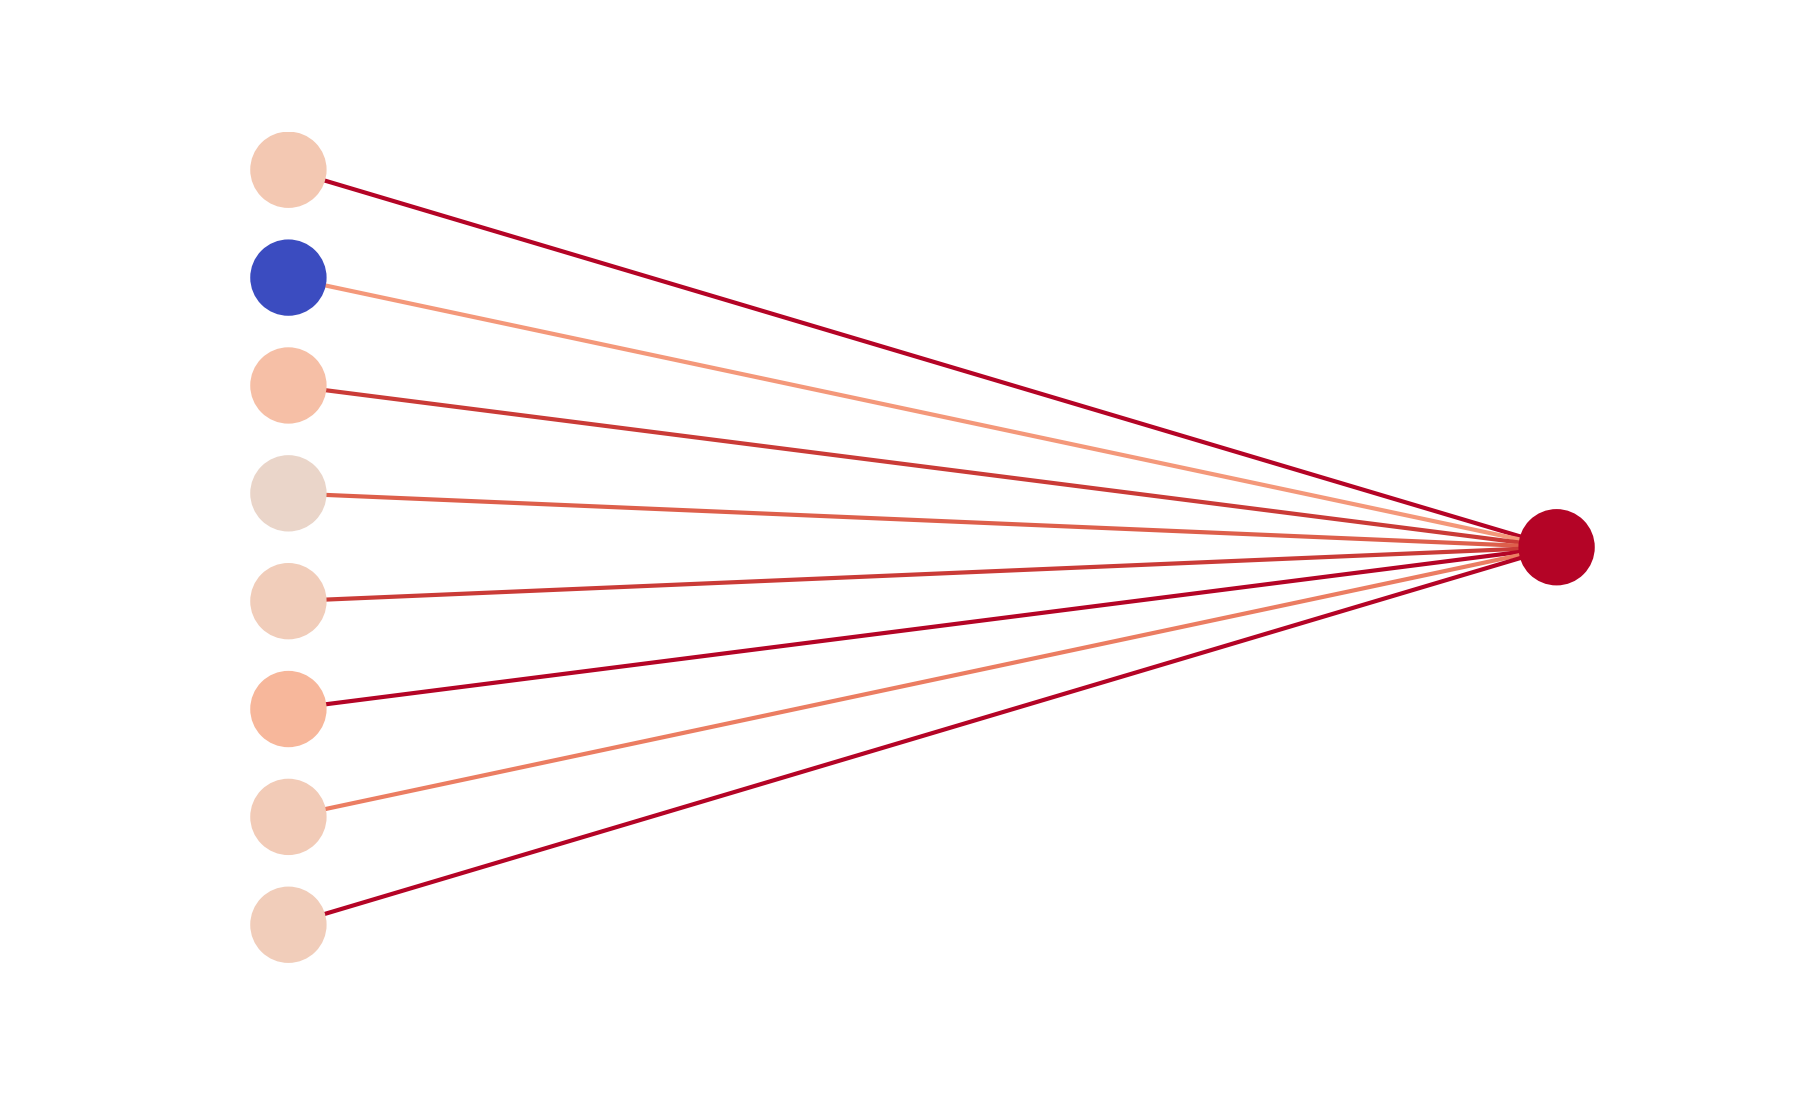

In [13]:
sf = "img/weightsum.png"
if not os.path.exists(sf) or REDRAW:
    plot_fcnn([8,1],(np.random.randint(4,10,8)/10).reshape(1,1,8),show_bar=False,input_array=np.random.random(8)-0.5,save=sf)
Image(sf,width=DEFAULT_IMG_PLOT_WIDTH)

In [14]:
display(md("Now the model contains as many trainable parameters as there are initial features ({})".format(len(c_atom_symbol_featurizer))))

Now the model contains as many trainable parameters as there are initial features (11)

where each feature describes whether the atom that is featurized is one of the following atoms (0 or 1):

In [15]:
atom_list=[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in c_atom_symbol_featurizer.describe_features()]
atom_list

['Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'other']

A carbon atom whould thus be represented by the feature vector:

In [16]:
np.array(c_atom_symbol_featurizer(Chem.Atom("C")))*1

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

It only takes a few epochs (iterations over the training data) for the model to completly tune the weights of the weighted-sum-network, resulting in a nearly perfect prediction. ()

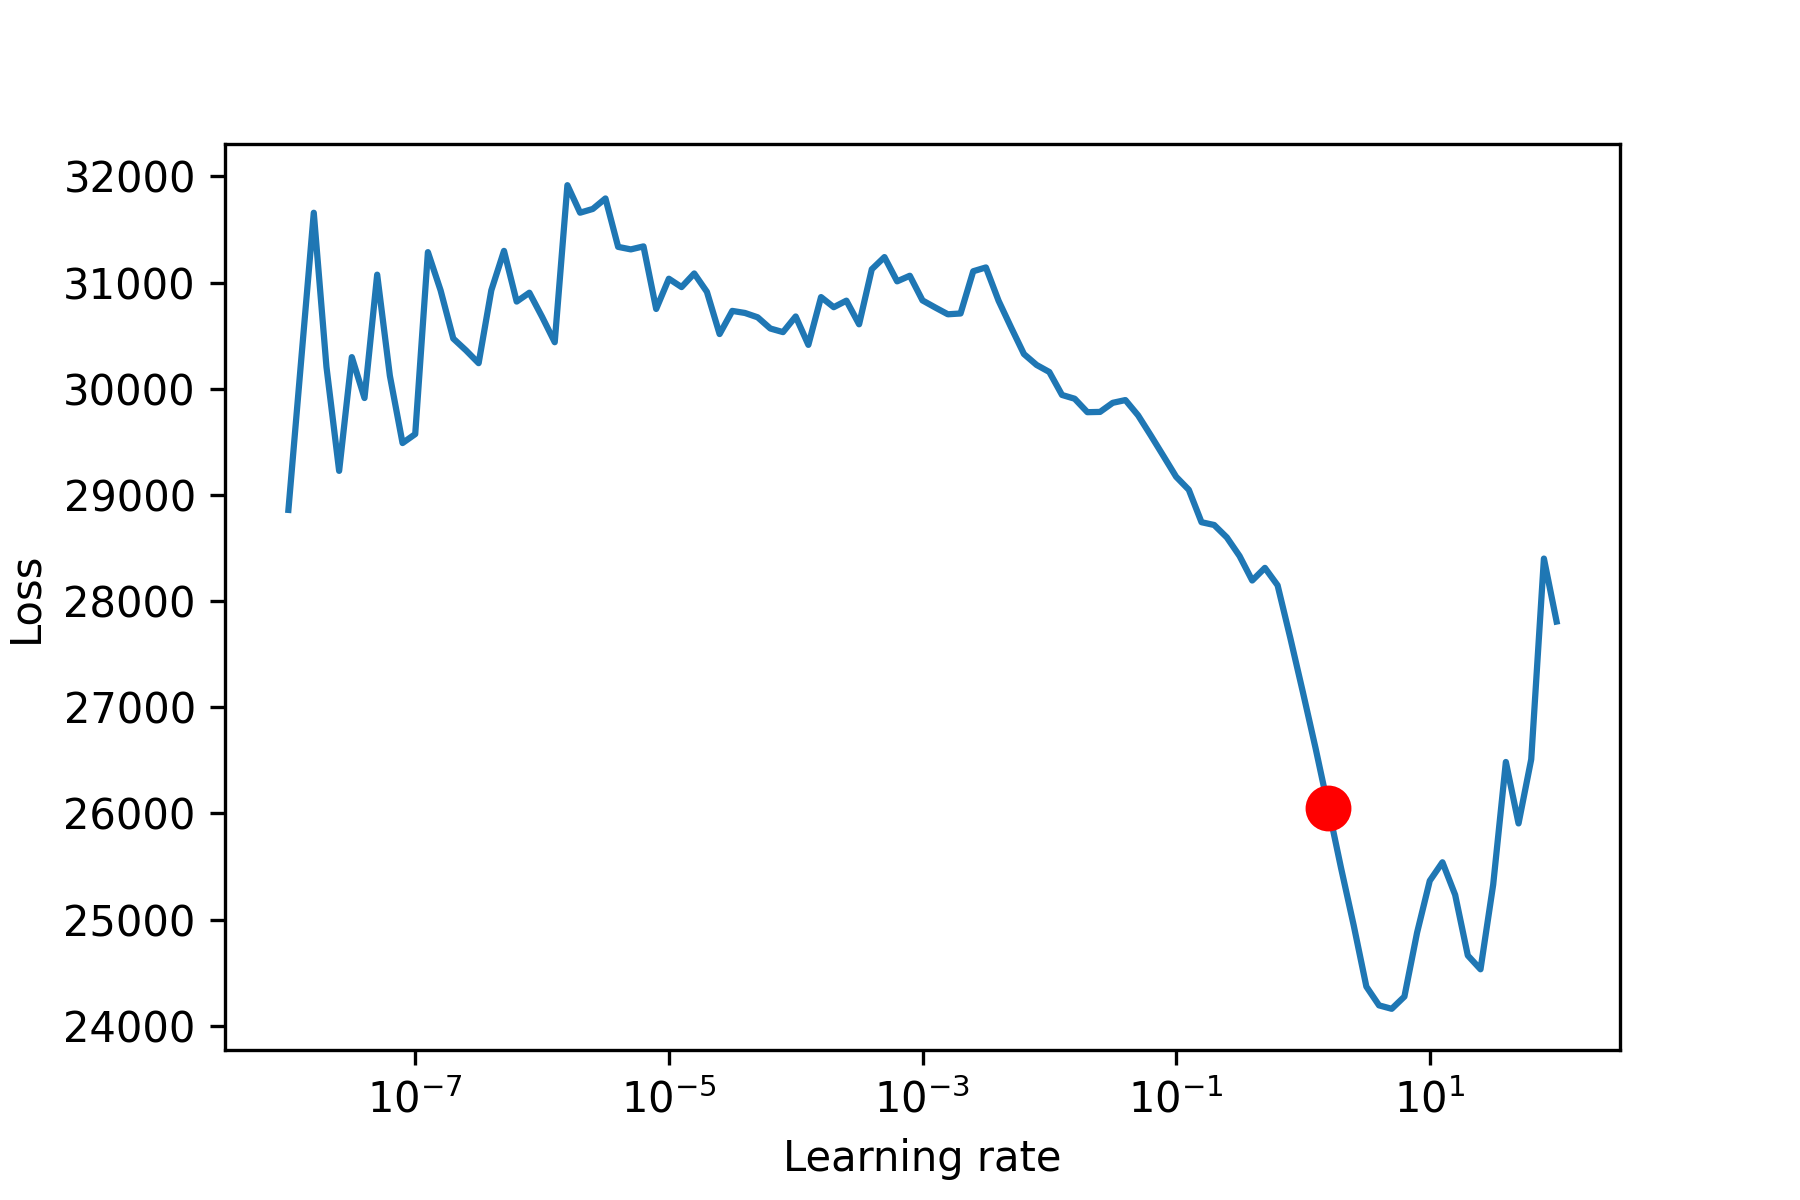

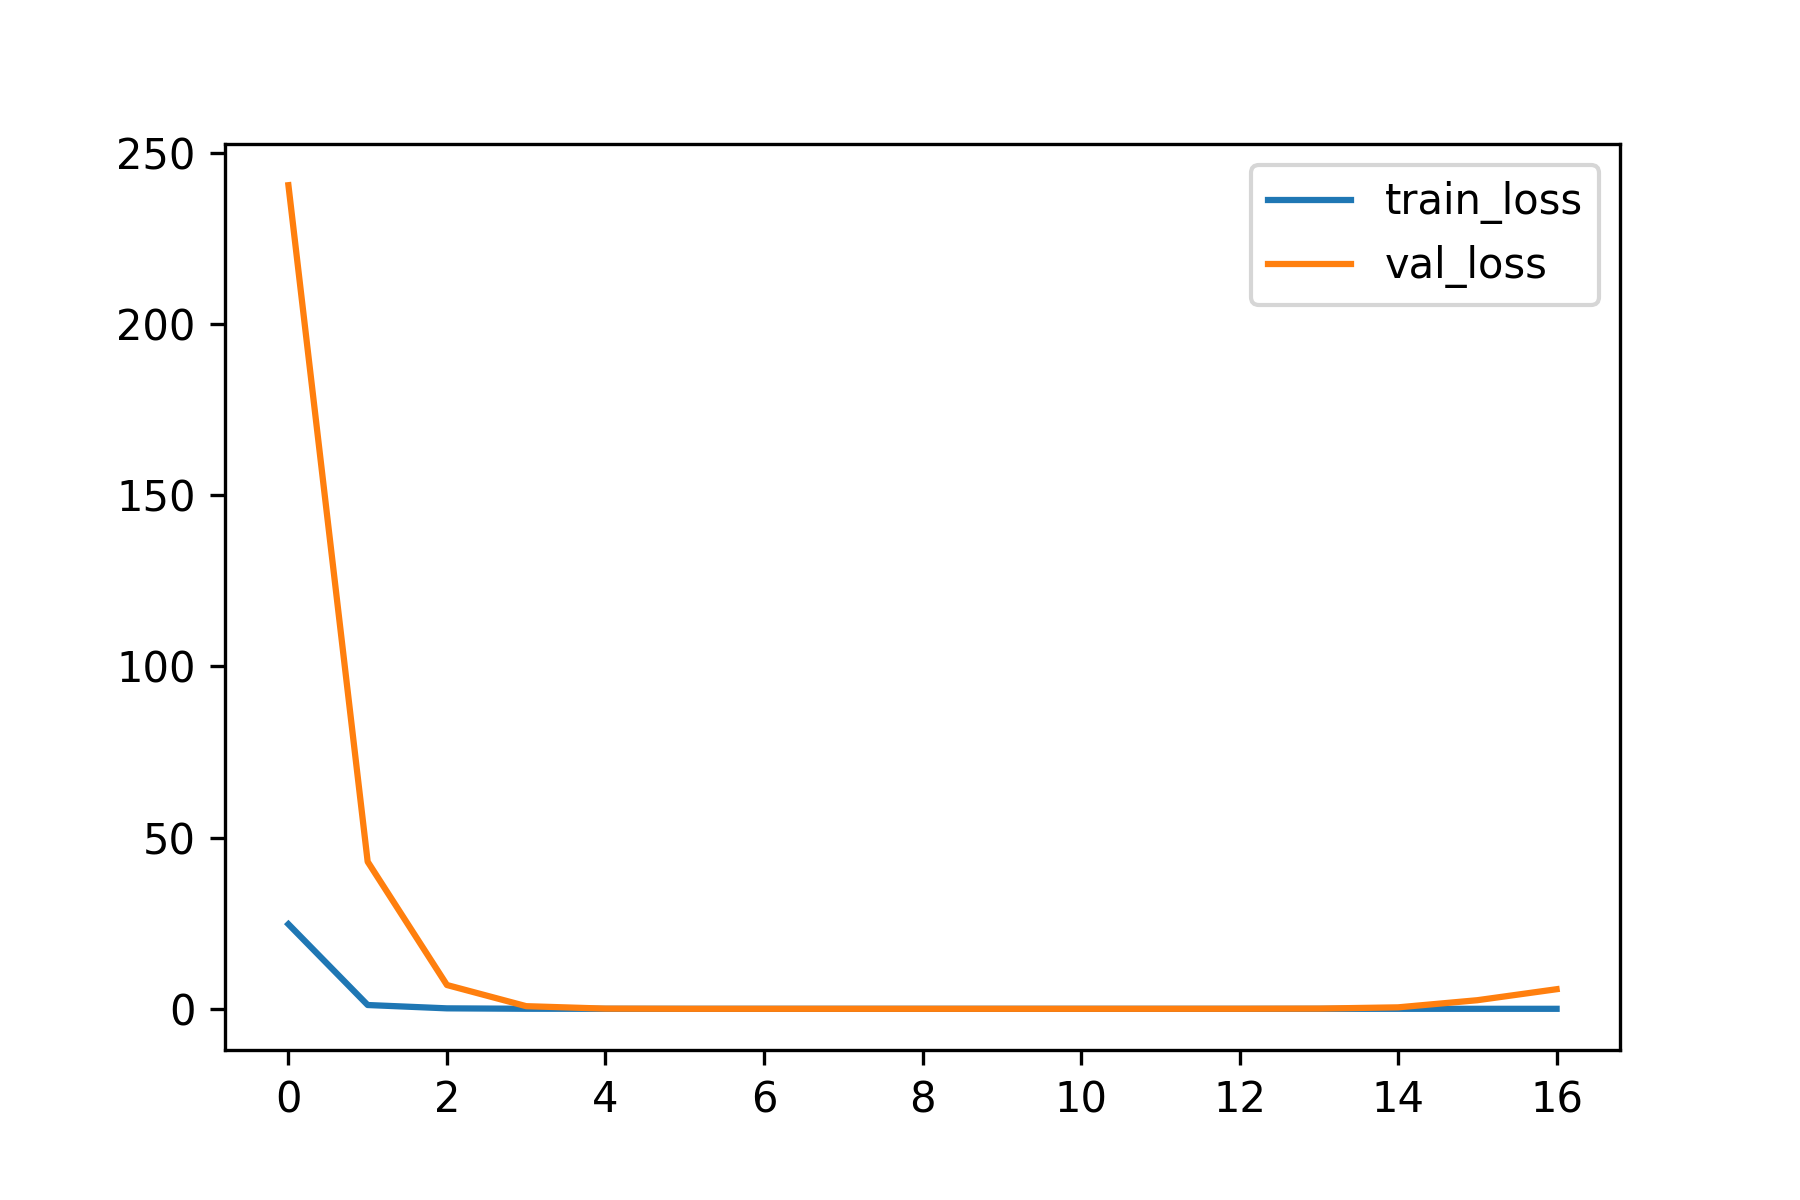

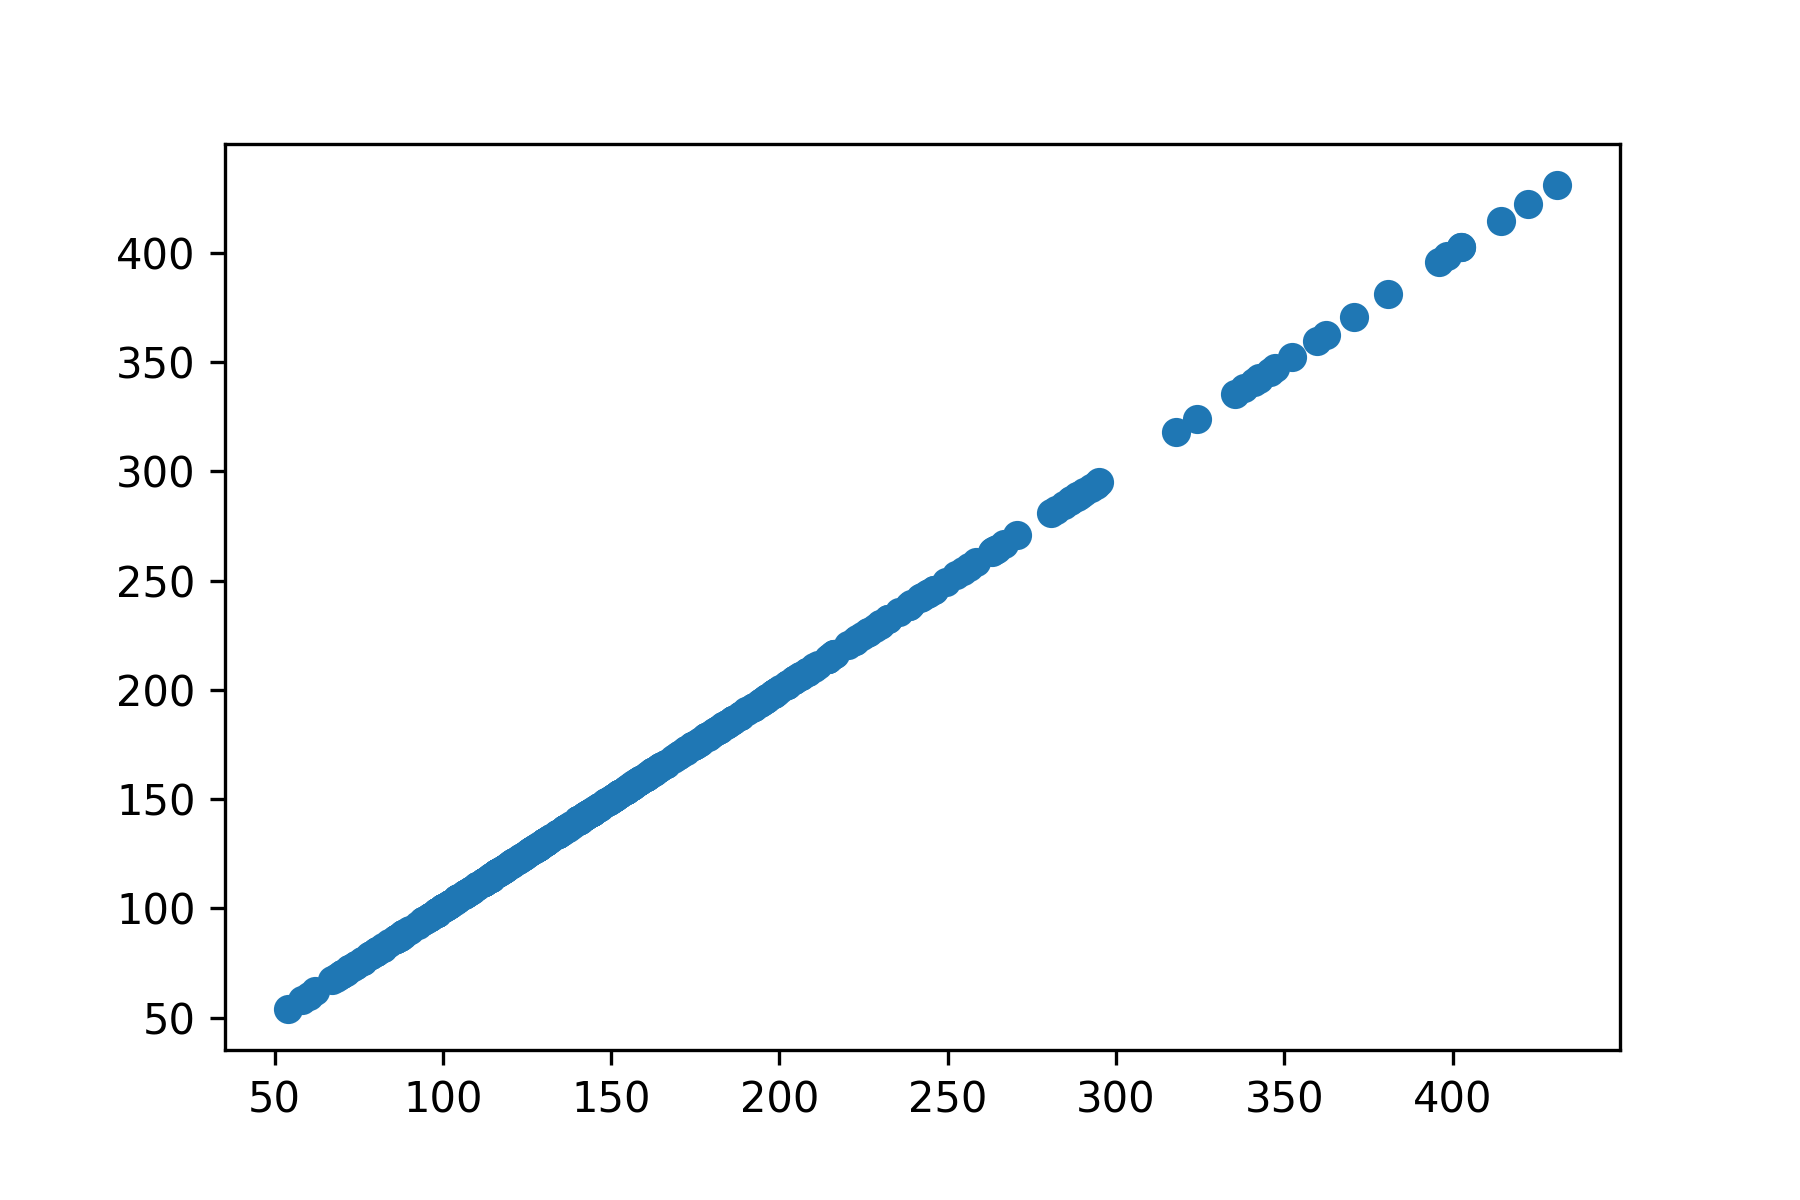

In [17]:
from molNet.featurizer.atom_featurizer import atom_symbol_one_hot
from torch_geometric.nn import GCNConv, GlobalAttention,global_add_pool
from molNet.nn.models.graph_convolution import PoolWeightedSum, PoolSum
import torch.nn.functional as F
import molNet.nn.functional as mF


class MolWeigtFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        self.pooling = PoolWeightedSum(in_size,normalize=False,bias=False)
        self.lr = 1e-1

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats = self.pooling(feats, batch)
        feats = torch.sum(feats,dim=1,keepdim=True)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        #print(y_hat.shape)
        #print(batch.y.shape)
        #raise ValueError()
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  F.mse_loss(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
            
loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["molar_mass"],
                                     seed=2,
                                     to_graph_params={"atom_featurizer":c_atom_symbol_featurizer,"with_mol_graph":True},
                                    batch_size=32,#num_workers=4
                                    )
model = MolWeigtFromTypeModel(in_size=len(c_atom_symbol_featurizer))

model,data = default_model_run("MolWeigtFromTypeModel",model,loader,
                  force_run=REMODEL,
                  force_test_data_reload=False
                               #min_epochs=15
                 )
#model.gcn(test_batch.x,test_batch.edge_index)
#model()

sample molecule:

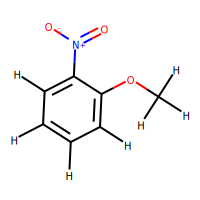

true (calculated) mass: 153.13699340820312 and predicted mass 153.13604736328125

true masses on each atom:

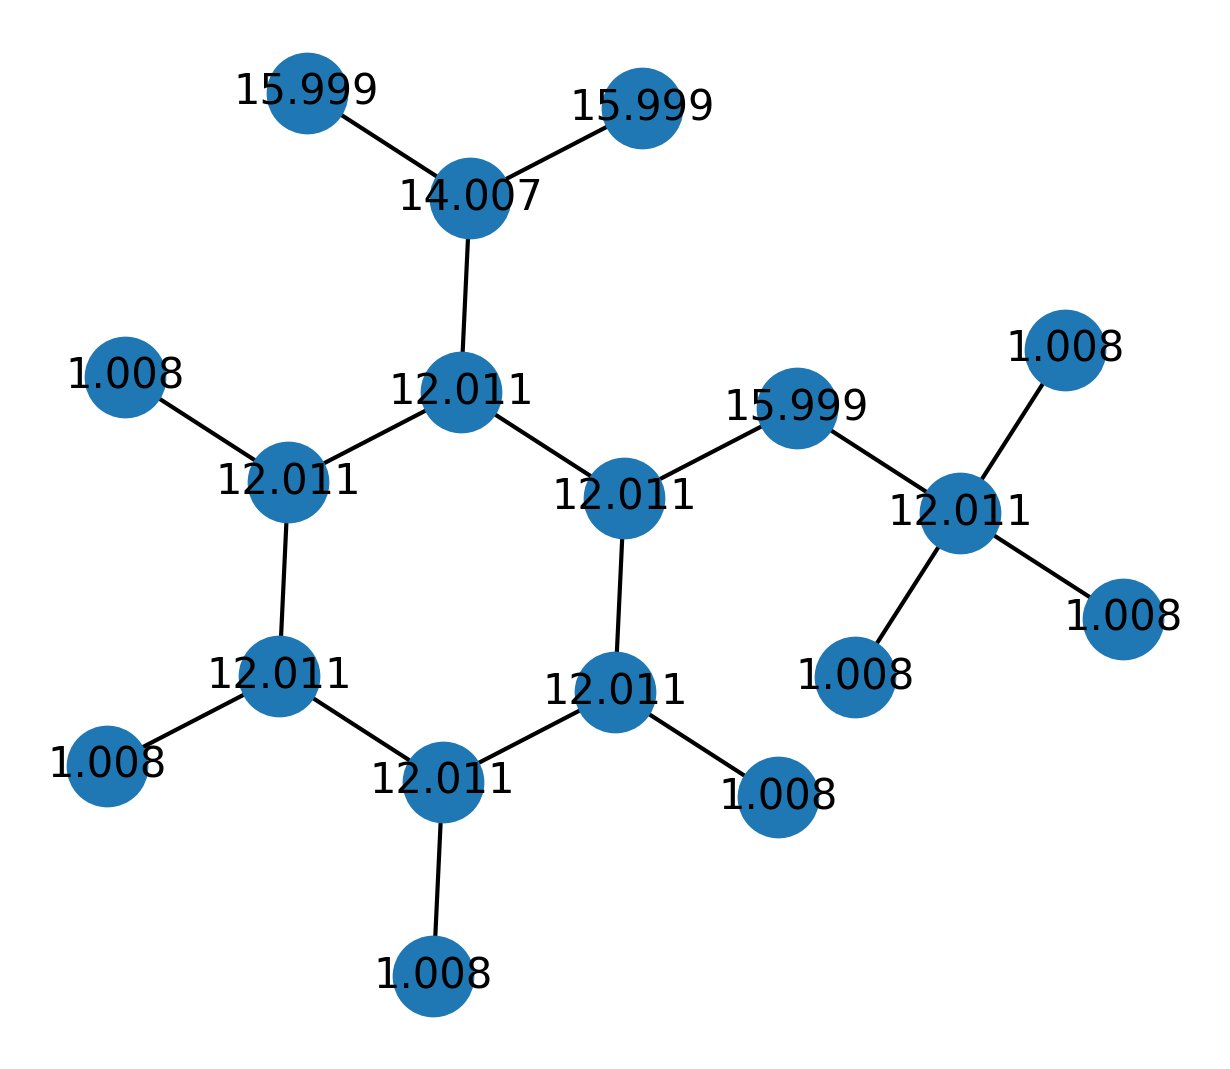

predicted masses on each atom:

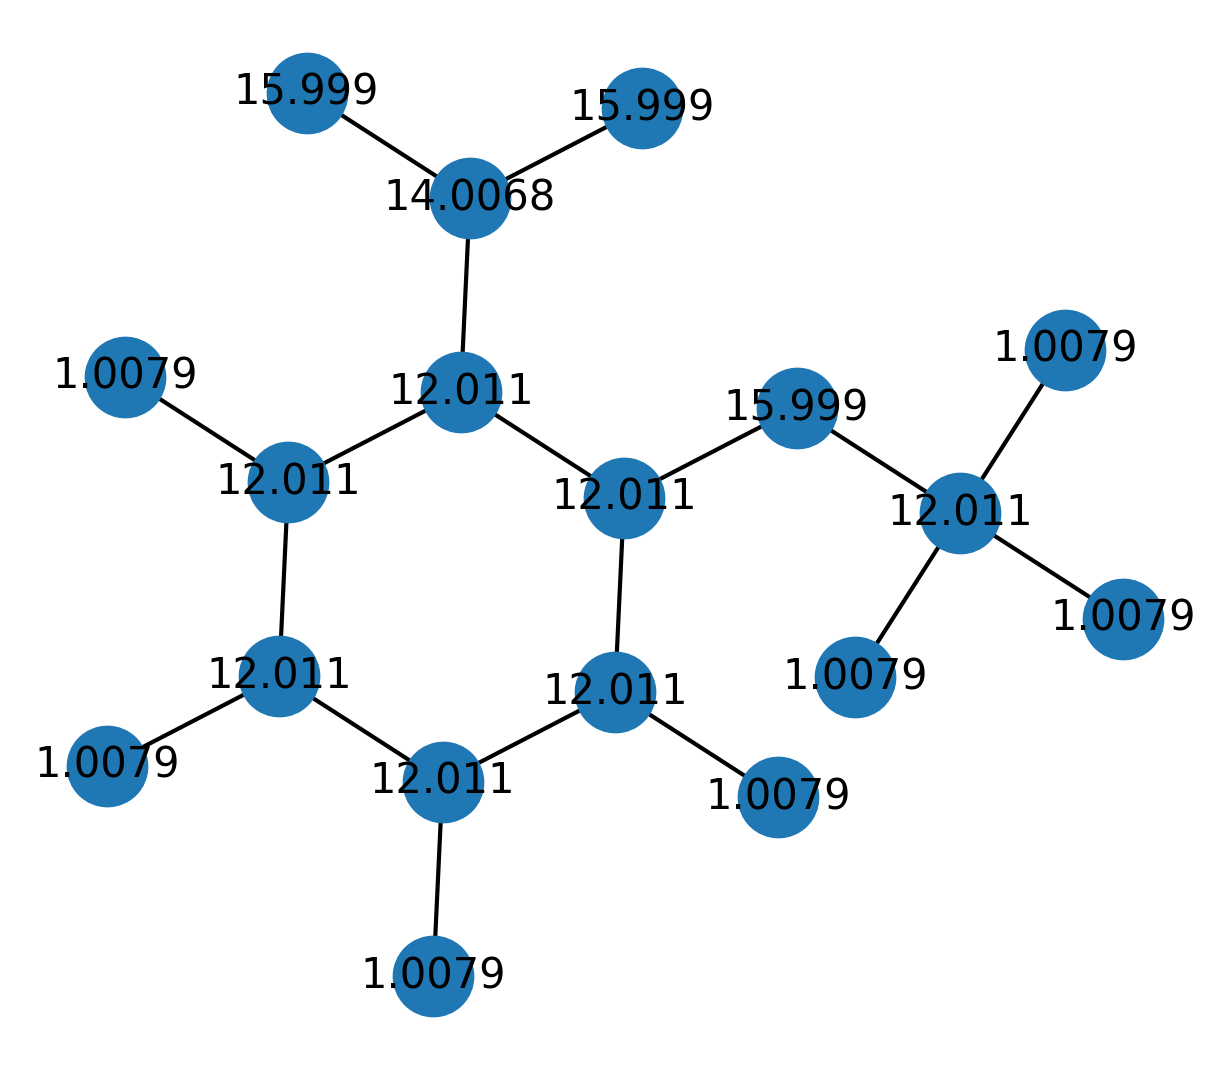

In [18]:
from rdkit.Chem.Draw import SimilarityMaps
test_data=data['test_data']
test_batch=data['test_batch']

display(md("sample molecule:"))
sf = os.path.join(data["files"]['plot_dir'],"sample_mol.svg")
if not os.path.exists(sf) or REDRAW:
    svg=test_data.mol_graph.molecule.to_svg()
    with open(sf,"w+") as f:
        f.write(svg)
display(SVG(sf))


prec=4

display(md("true (calculated) mass: {} and predicted mass {}".format(test_data.y[0][0],model(test_batch)[0][0])))


display(md("true masses on each atom:"))
sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_target.png")
if not os.path.exists(sf) or REDRAW:
    target_graph = [atom.GetMass() for atom in test_data.mol_graph.mol.GetAtoms()]
    l = [np.format_float_positional(c,precision=prec) for c in target_graph]
    f = test_data.mol_graph.get_fig(labels=l)
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))


display(md("predicted masses on each atom:"))
sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_predict.png")
if not os.path.exists(sf) or REDRAW:
    conv = test_batch.x.detach().numpy()#.flatten()
    conv=np.argmax(conv,axis=1)
    conv = model.pooling.weighting_of_nodes.weight[0][conv].detach().numpy()
    l = [np.format_float_positional(c,precision=prec) for c in conv]
    f = test_data.mol_graph.get_fig(labels=l)
    sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_predict.png")
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

As can be seen the atomic mass prediction is quite good and correct up o the third decimal place. The difference will become smaller if trained for mor epochs but at some point the gain will be dimishing small.
If we take a closer look at the weights from the weight-sum-network, it becomes clear, that the weights simply became tuned to the individual masses of the atom types and thus the output becomes the mass of the aotom whos featuer vector was feed into the network (note that other is a placeholder for all atoic symbols not in the feature vector, if none are present it's value is random):

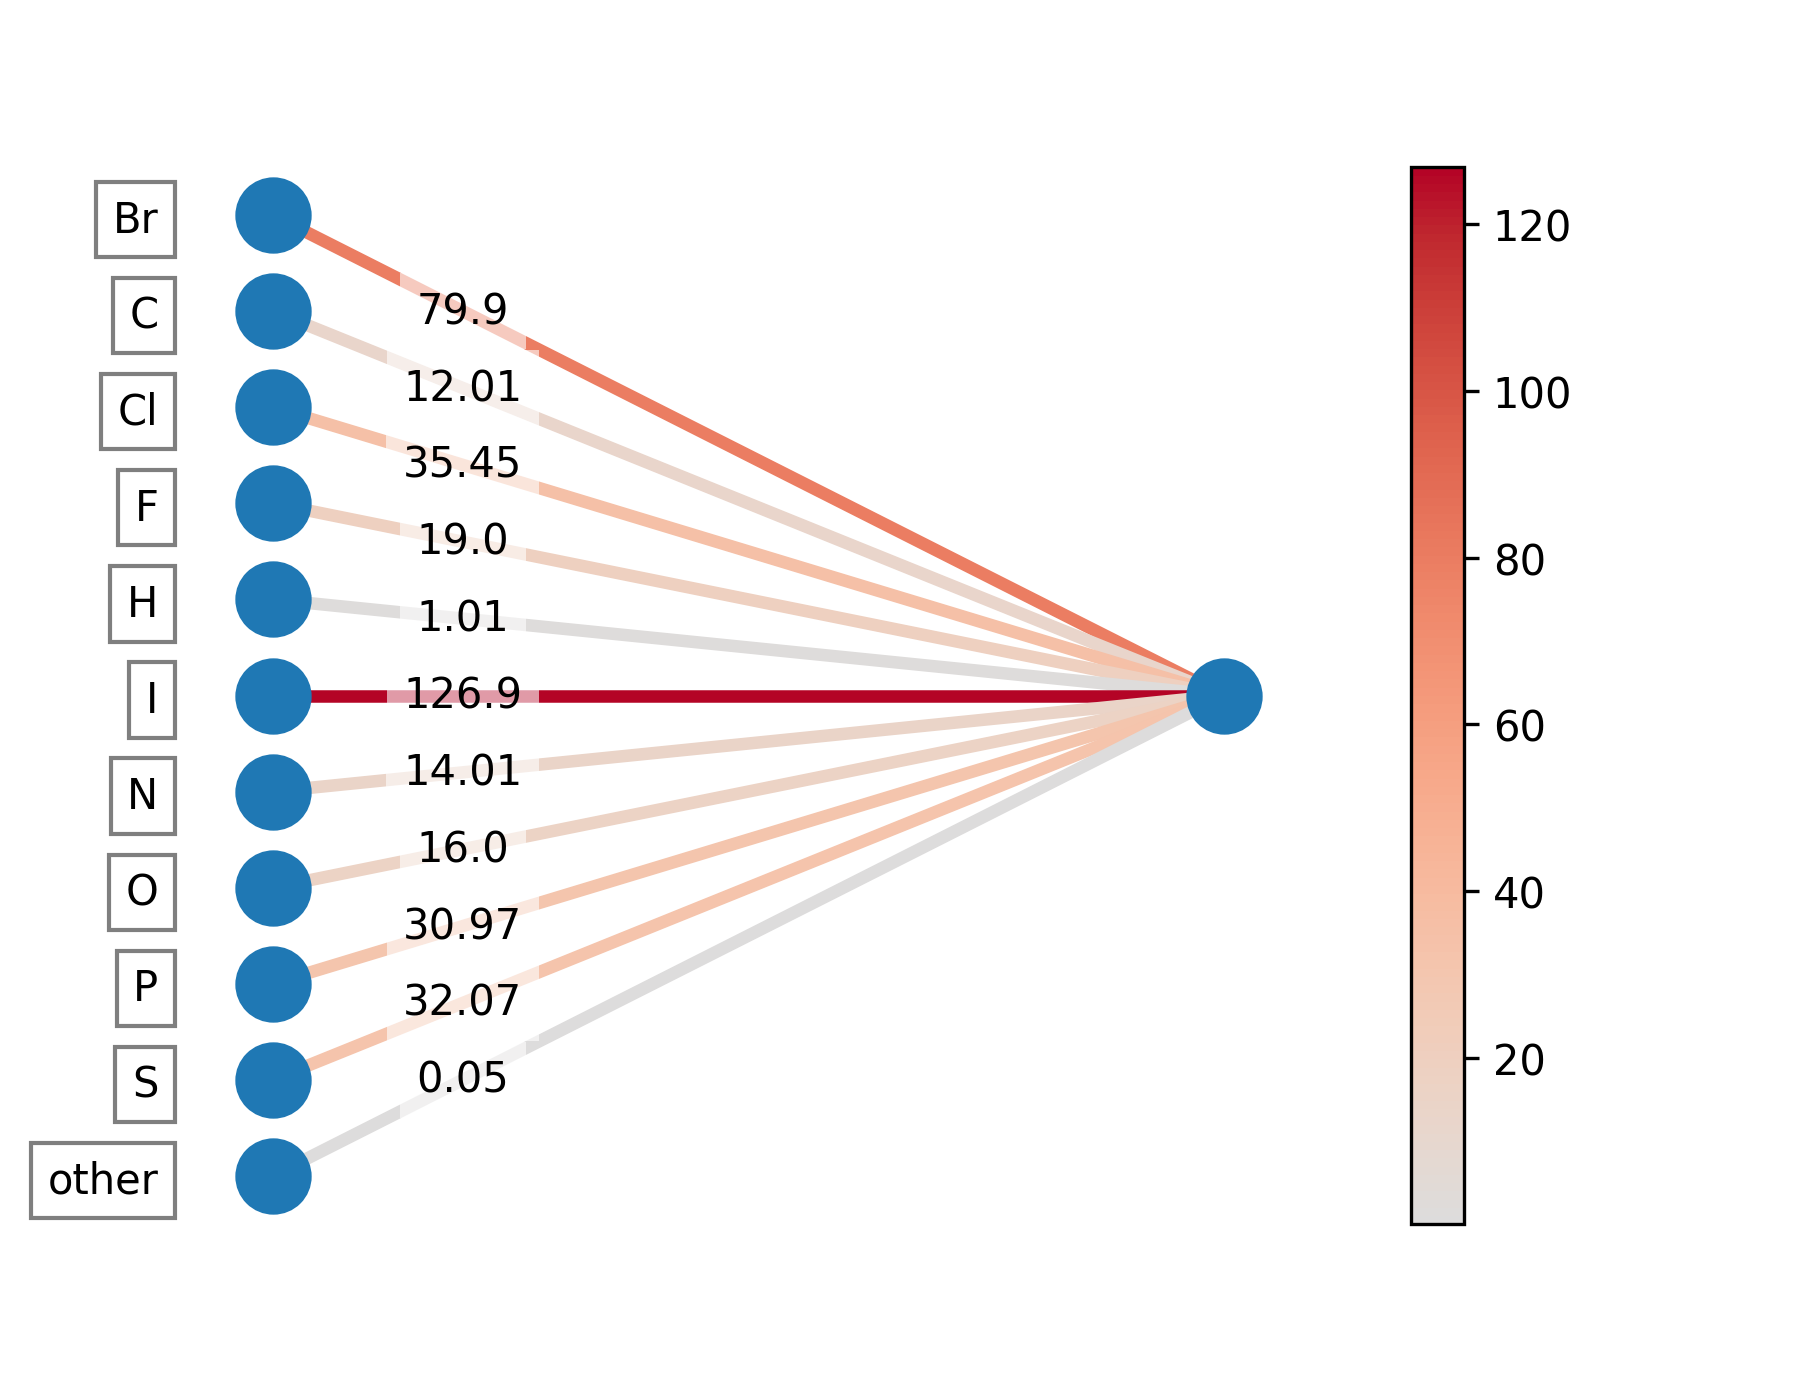

In [19]:
sf = os.path.join(data["files"]['plot_dir'],"weight_sum_net.png")
if not os.path.exists(sf) or REDRAW:
    plot_fcnn([11,1],
              [model.pooling.weighting_of_nodes.weight.detach().numpy()],
          show_bar=True,
          input_labels=[f.replace("custom_atom_symbol_one_hot: ","").replace("None","other") for f in c_atom_symbol_featurizer.describe_features()],
          weight_position=0.2,edge_width=3,
          save=sf
         )
Image(sf,width=DEFAULT_IMG_PLOT_WIDTH)

Up until know we've only dealt with predicion based on individual atoms which are complete independend from the bonds beween them. thus we never had to use graph concoluional models, which are used to transfer features from one node (atom) to a conencted one.

Another way to understand this is to think about the featurizer as a tool creating one or muliple copies of the initial graph - in this case the graph of the molecular structure -
and each of the nodes in each graph can hold exactly one value. Pooling takes each subgraph and merges als if its nodes into the a single single value. The lengh of the resulting pooling operation is equal to the number of features the pooling is applied to.
In the above example the featurizer creates subgraphs whos value are determined by the underliing atomic symbol:

In [20]:
def gallery(images, height='auto',captions=None):
    if isinstance (height,(int,float)):
        height=str(height)+"px"
    if not captions:
        captions=[None]*len(images)
    if len(captions)<len(images):
        captions = captions + [None]*(len(captions)-len(images))
        
    figures = []
    for i,image in enumerate(images):
        src = image
        caption = f'<figcaption>{captions[i]}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {height}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

images=[]
for c in range(test_data.x.shape[1]):
    sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_feature_{}.png".format(atom_list[c]))
    if not os.path.exists(sf) or REDRAW:
        target_graph = test_data.x[:,c]
        l = [np.format_float_positional(c,precision=prec) for c in target_graph]
        f = test_data.mol_graph.get_fig(labels=l)
        plt.savefig(sf,dpi=DEFAULT_DPI)
        plt.close()
    images.append(sf)
    #display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH/2))
    
gallery(images,height=DEFAULT_IMG_PLOT_WIDTH/2,captions=atom_list)

    
#sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_target.png")
#plt.savefig(sf,dpi=DEFAULT_DPI)
#plt.close()
#display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

Each graph ist then multiplied with the respective weight of the weighted sum pooling layer:

In [21]:
images=[]
for c in range(test_data.x.shape[1]):
    sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_feature_{}_weighted.png".format(atom_list[c]))
    if not os.path.exists(sf) or REDRAW:
        target_graph = test_data.x[:,c]
        target_graph = target_graph*model.pooling.weighting_of_nodes.weight[0,c]
        l = [np.format_float_positional(c,precision=prec) for c in target_graph]
        f = test_data.mol_graph.get_fig(labels=l)
        plt.savefig(sf,dpi=DEFAULT_DPI)
        plt.close()
    images.append(sf)
    #display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH/2))
    
gallery(images,height=DEFAULT_IMG_PLOT_WIDTH/2,captions=atom_list)

Then sum pooling over each feature graph is applied, giving the sum of masses of each atom type in the molecule:

In [22]:
s=0
for c in range(test_data.x.shape[1]):
    target_graph = test_data.x[:,c]
    target_graph = target_graph*model.pooling.weighting_of_nodes.weight[0,c]
    pool=float(torch.sum(target_graph))
    s+=pool
    print(atom_list[c]+":",pool)

Br: 0.0
C: 84.07694244384766
Cl: 0.0
F: 0.0
H: 7.055301189422607
I: 0.0
N: 14.006814956665039
O: 47.996986389160156
P: 0.0
S: 0.0
other: 0.0


In [23]:
md("resulting in the total mas of {} g/mol. Which is pretty much the same as the true value of {} g/mol".format(s,float(test_data.y)) )

resulting in the total mas of 153.13604497909546 g/mol. Which is pretty much the same as the true value of 153.13699340820312 g/mol

A property that cannot directly deriven from the atomic symbol is hybridization, since it depends (in general) on the atom and the number of connected atoms (e.g. Carbon with  connections to four other atoms is $sp^3$-hybridized and with three connections is $sp^2$-hybridized and Oxigen with 

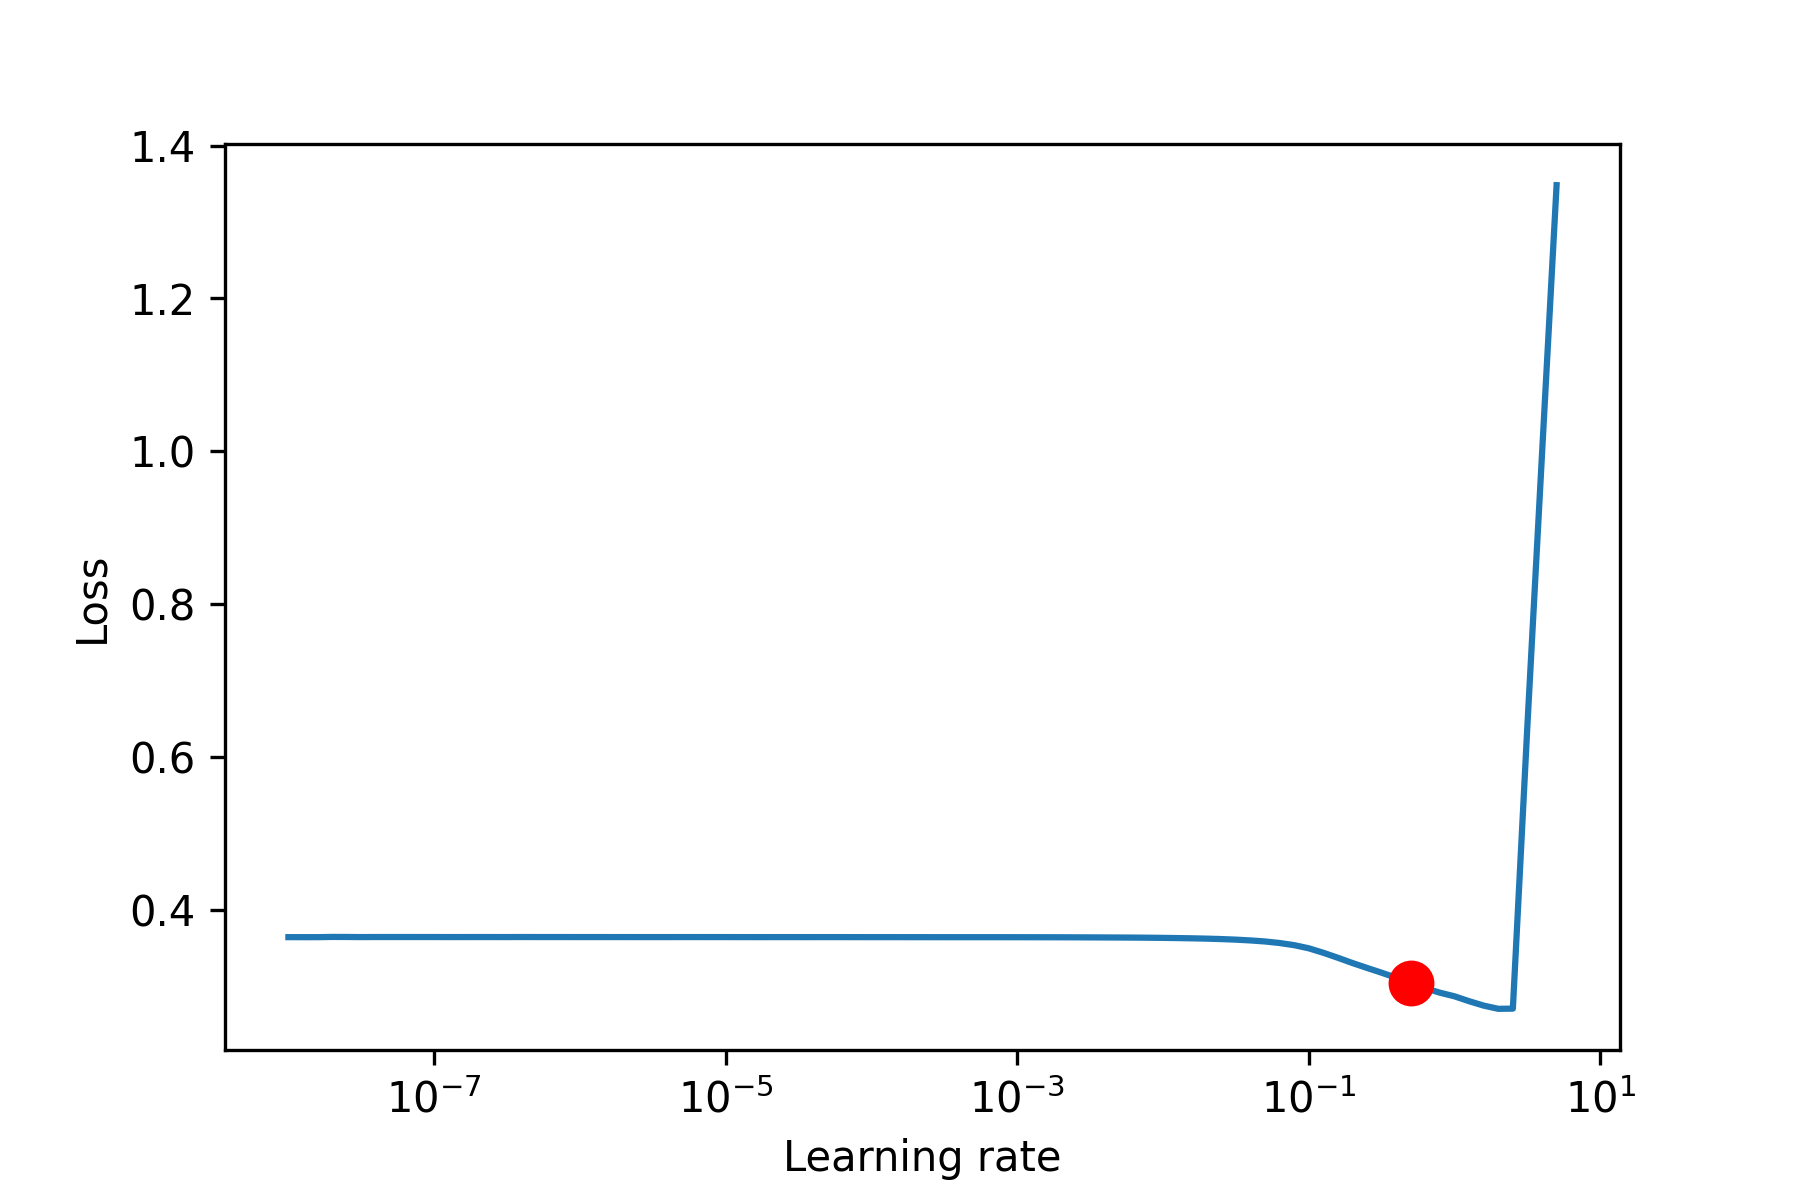

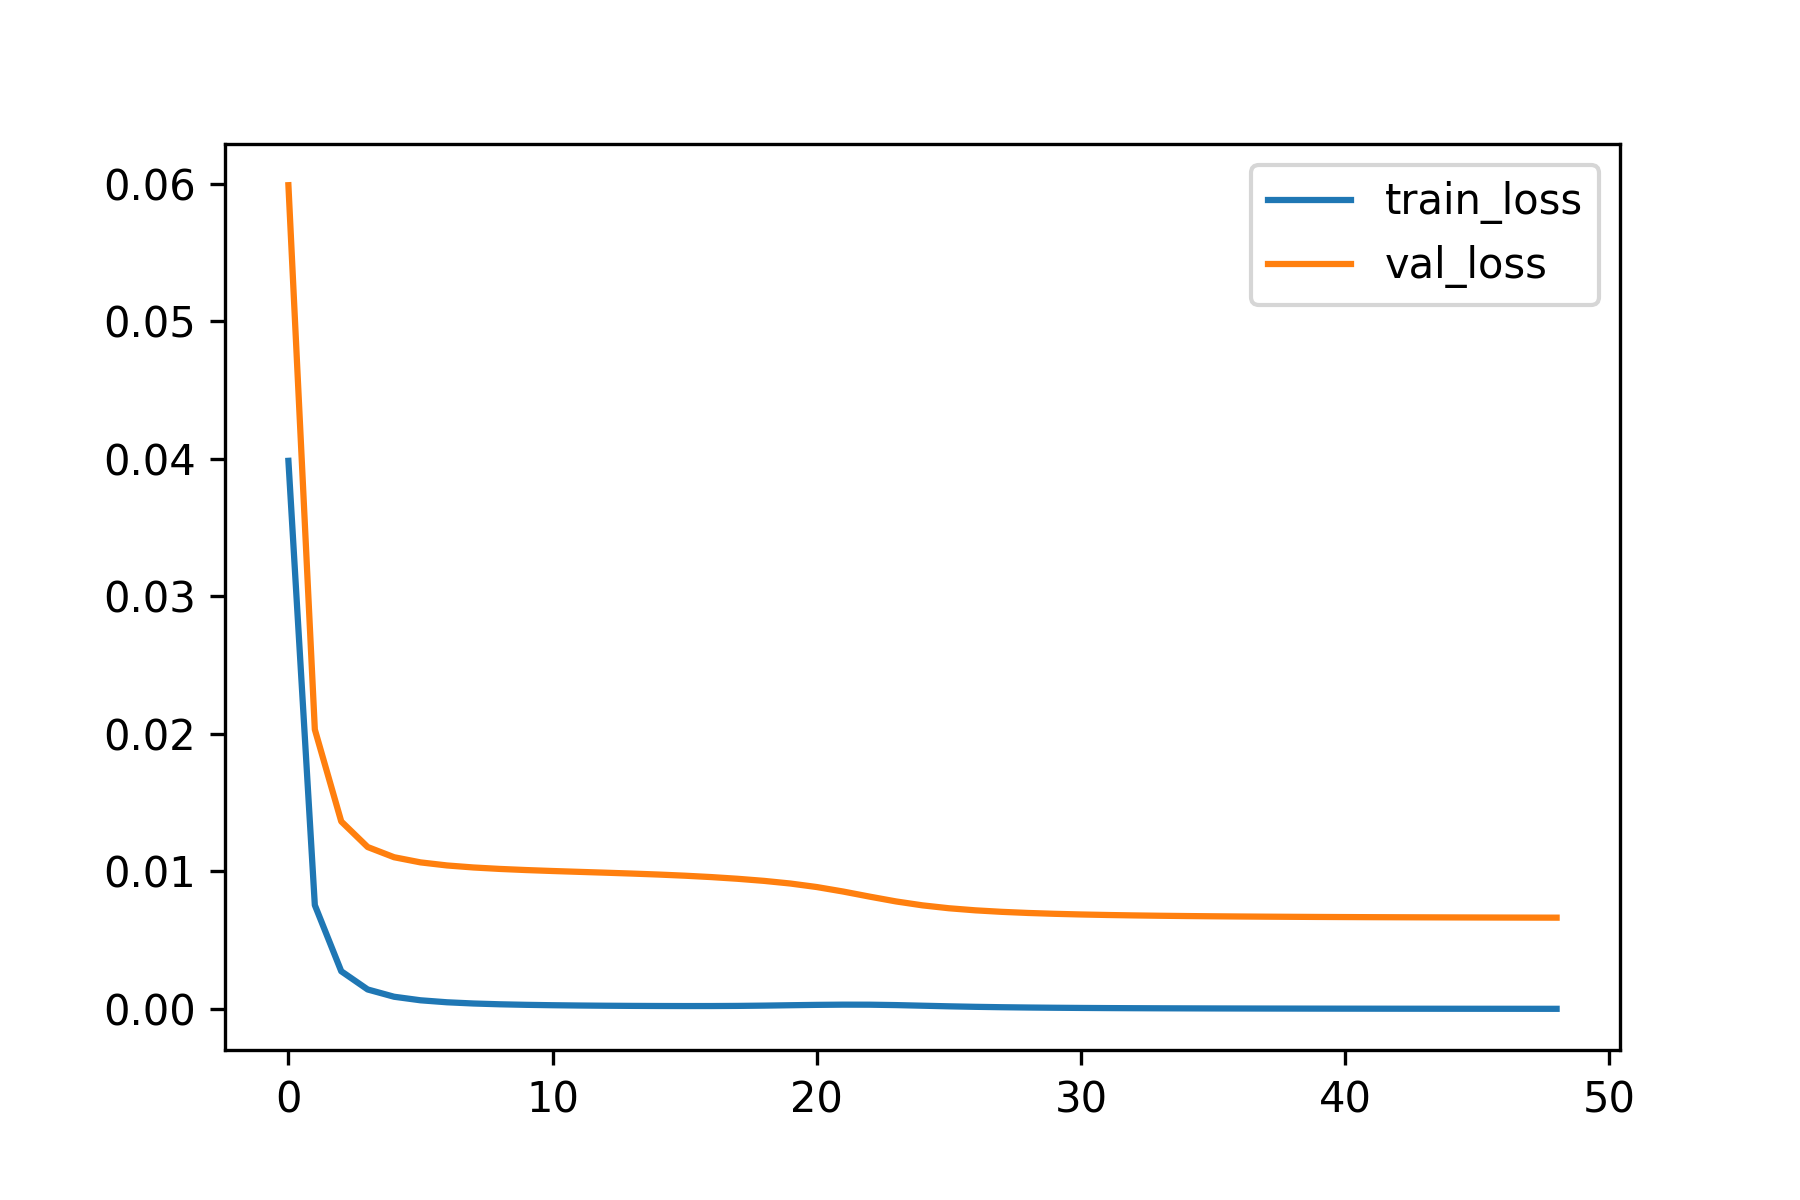

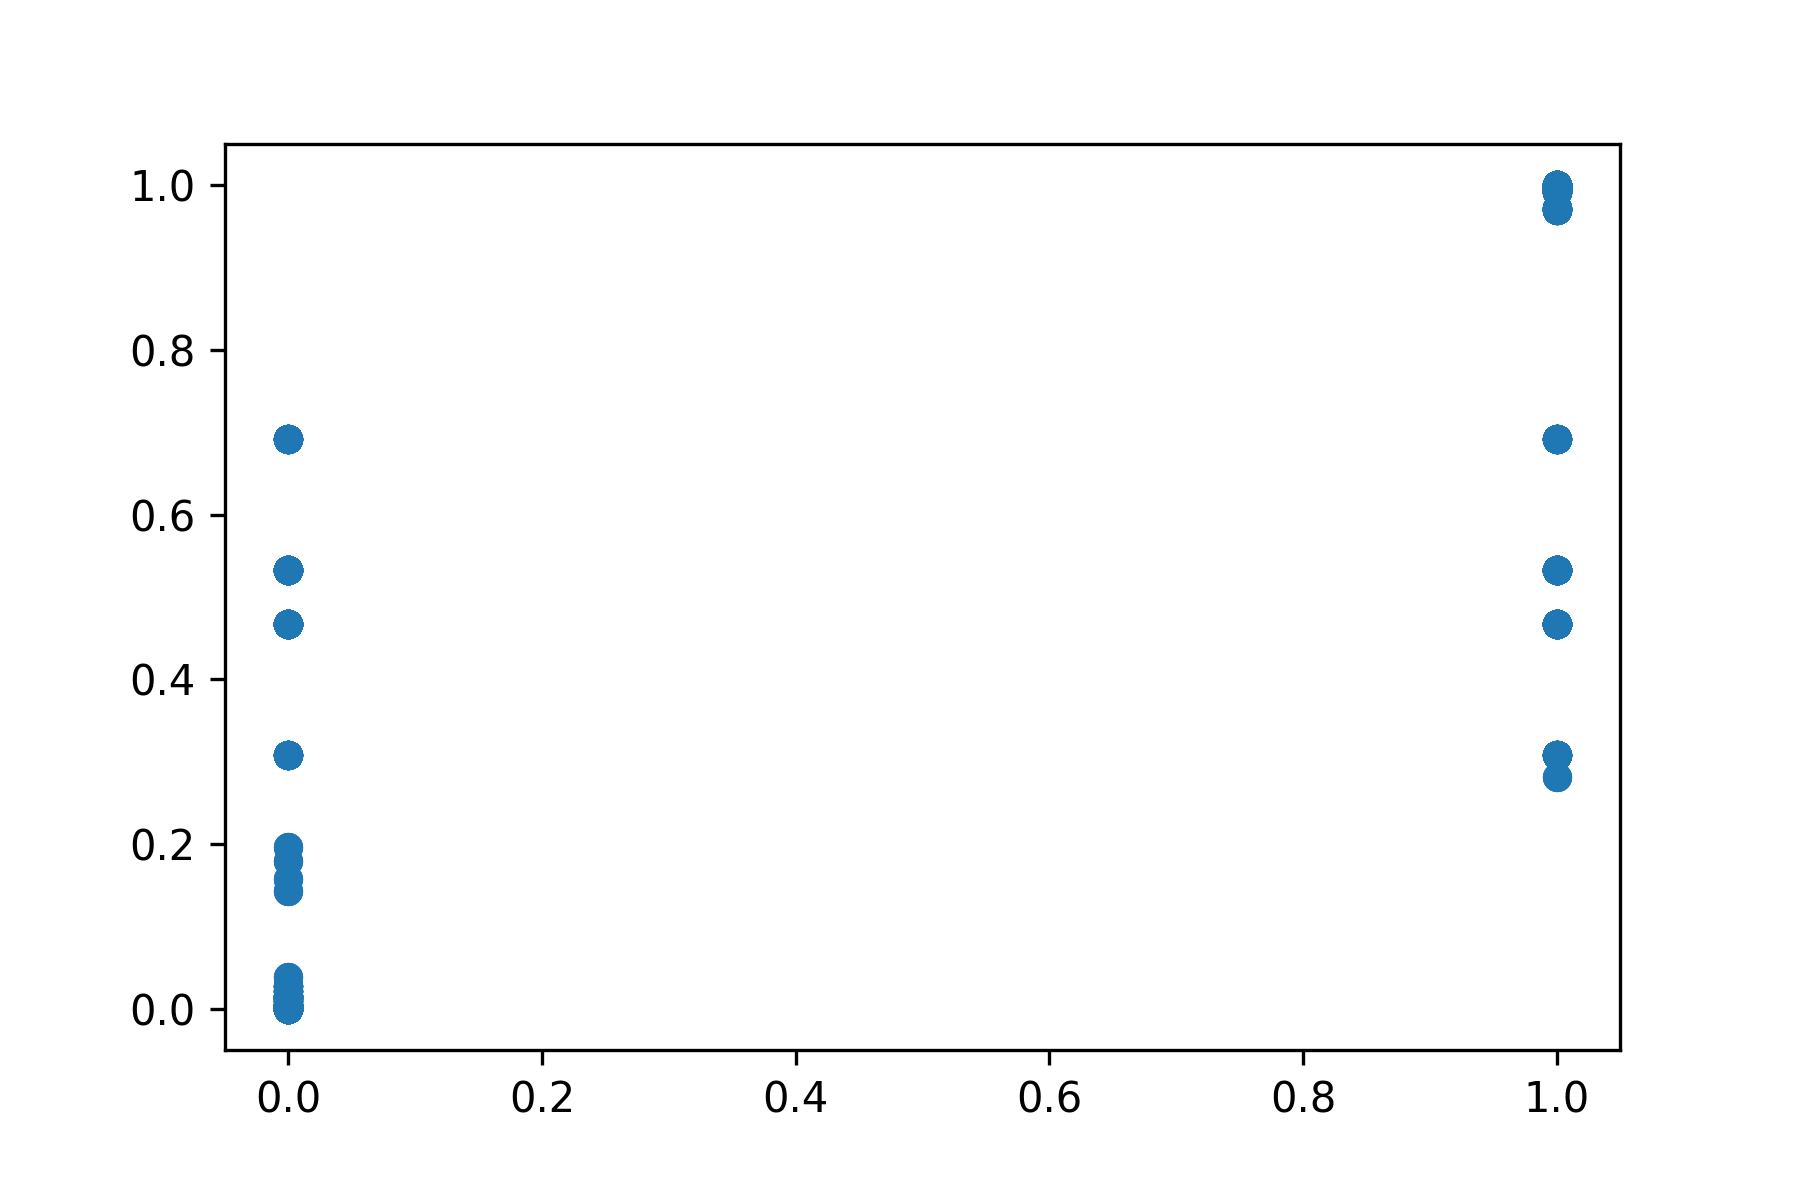

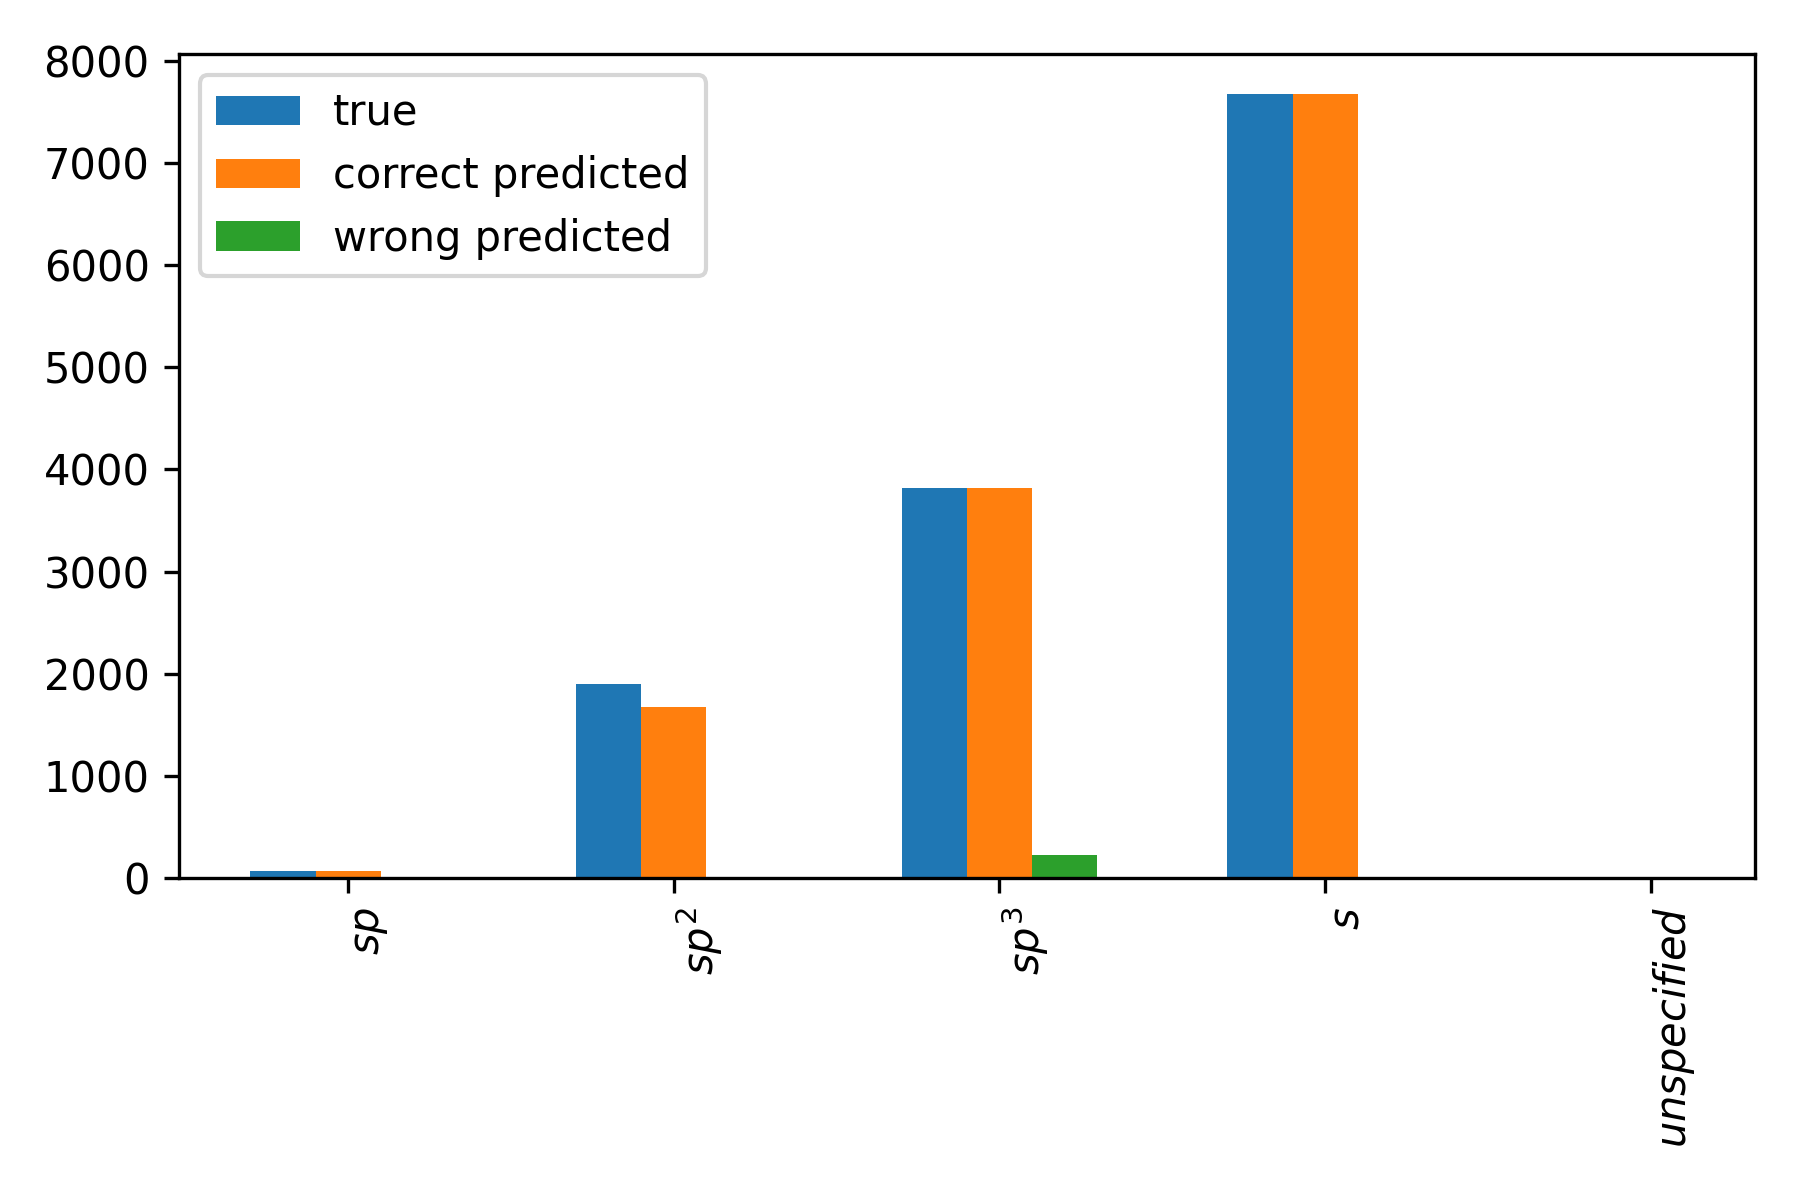

In [24]:
from molNet.featurizer.atom_featurizer import atom_hybridization_one_hot,atom_degree_one_hot

featurizer=c_atom_symbol_featurizer+atom_degree_one_hot
class HybridizationFromTypeModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        out_size=len(atom_hybridization_one_hot)
        
        med_size=2
        
        self.nn1 = torch.nn.Linear(in_size, med_size,bias=False)
        self.nn2 = torch.nn.Linear(med_size, out_size,bias=False)
        
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.lr = 1e-2
        
        self.lossf=F.binary_cross_entropy#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        feats =self.nn1(feats)
        feats =self.nn2(feats)
        feats = self.softmax(feats)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        #print(y_hat[0],batch.y[0],loss)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
            
loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["hybridization"],
                                     seed=1,
                                     to_graph_params={
                                         "atom_featurizer":featurizer,
                                         "with_mol_graph":True
                                     },
                                    batch_size=32,#num_workers=4
                                    follow_batch=["y"]
                                    )
model = HybridizationFromTypeModel(in_size=len(featurizer))

short_hybrid = np.array(["$"+s.split()[1].lower().replace("2","^2").replace("3","^3")+"$" for s in atom_hybridization_one_hot.describe_features()])


model,data = default_model_run("HybridizationFromTypeModel",model,loader,
                  force_run=REMODEL,
                  #force_test_data_reload=True,
                #min_epochs=25,
                               #early_stopping=True,
                               #max_epochs=50,
                               detect_lr=False,
                categories=short_hybrid.tolist(),
)
test_data=data['test_data']
test_batch=data['test_batch']

As can be seen, model predicts the true hybridization correctly for nearly every atom in the test data.
(Note that most atoms have a 'ubspecified' hybridization. Most of these atoms are hydrogens which only have a single occupied $1s$ orbital and thus cannot hybridize)

The network that predicts the hybrodiztion from atom type and degree can be representet as:

(2, 19)

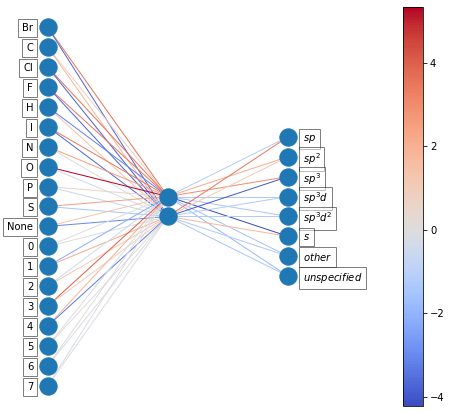

In [25]:
worked=[]
weights1=model.nn1.weight.detach().numpy().copy()
weights2=model.nn2.weight.detach().numpy().copy()

display(weights1.shape)

plot_fcnn([len(featurizer),
           weights1.shape[0],weights2.shape[0]
          ],
          weights=[weights1,weights2],
          input_labels=[s.split(": ")[1] for s in featurizer.describe_features()]+
          [None]*weights1.shape[0]+short_hybrid.tolist(),
              hide_loose=True,
              show_bar=True
             )


even this very small network which is hard to interpret if one looks at the complete structure all at once. It is much easier to look at only the important parts for certain inputs and try to get how the output is created:
For example if we use

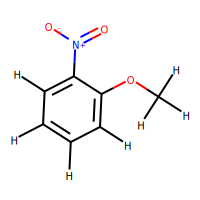

1-Methoxy-2-nitrobenzene


In [26]:
display(test_data.mol_graph.molecule)
print(test_data.mol_graph.molecule.name)

As input the resulting prediction can be represented on the molecular graph as:

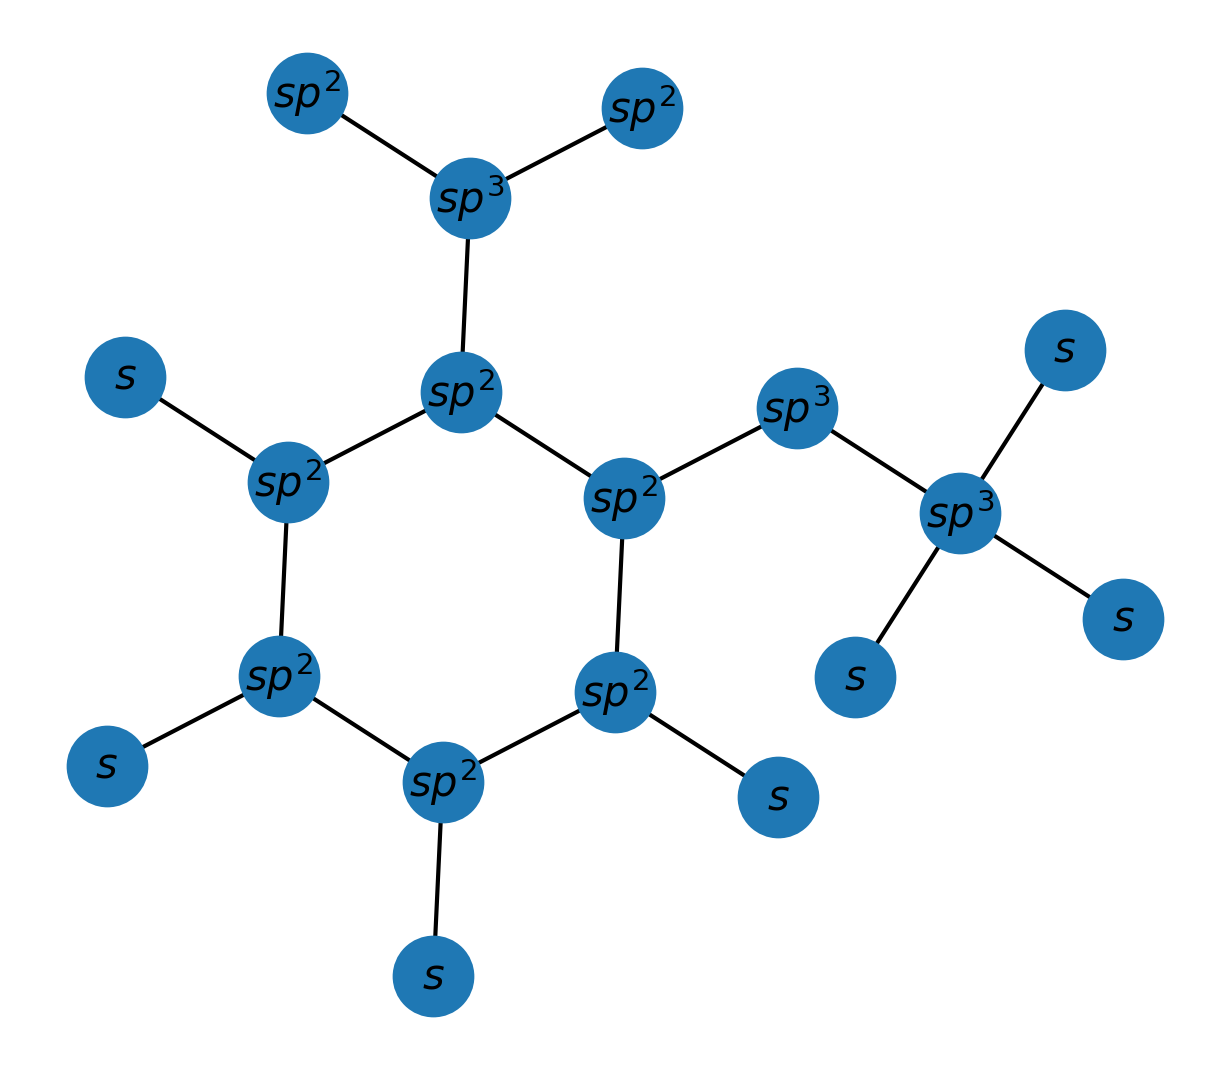

In [27]:
sf=os.path.join(data["files"]['plot_dir'],"sample_mol_graph_hybridization_pred.png".format(atom_list[c]))
if not os.path.exists(sf) or REDRAW or True:
    l = short_hybrid[model(test_batch).detach().numpy().argmax(1)].tolist()
    f = test_data.mol_graph.get_fig(labels=l)
    plt.savefig(sf,dpi=DEFAULT_DPI)
    plt.close()
    
display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))

in this structure all possible combinations of atom time and degree of bonds, and thus all possible input combinations, are:

In [28]:
possible_input_tensors = []
possible_input_arrays = []
for x in test_data.x:
    x_array=x.detach().numpy()
    if len(possible_input_arrays)>0:
        if any((np.array(possible_input_arrays)[:] == x_array).all(1)):
            continue
    possible_input_tensors.append(x)    
    possible_input_arrays.append(x_array)

feature_desc=np.array(
    [s.split(": ")[1]
     for s in featurizer.describe_features()
    ]
)
for i in range(len(possible_input_arrays)):
    x_array=possible_input_arrays[i].astype(bool)
    atom_desc = feature_desc[x_array]
    display(md("Atom '{}' with {} connections".format(atom_desc[0],atom_desc[1])))

Atom 'H' with 1 connections

Atom 'C' with 3 connections

Atom 'O' with 2 connections

Atom 'N' with 3 connections

Atom 'O' with 1 connections

Atom 'C' with 4 connections

for each if this possible inputs the relevant network structure can be extracted and since it's a much smaller part of the network interpreted much easier

For Atom 'H' with 1 connections

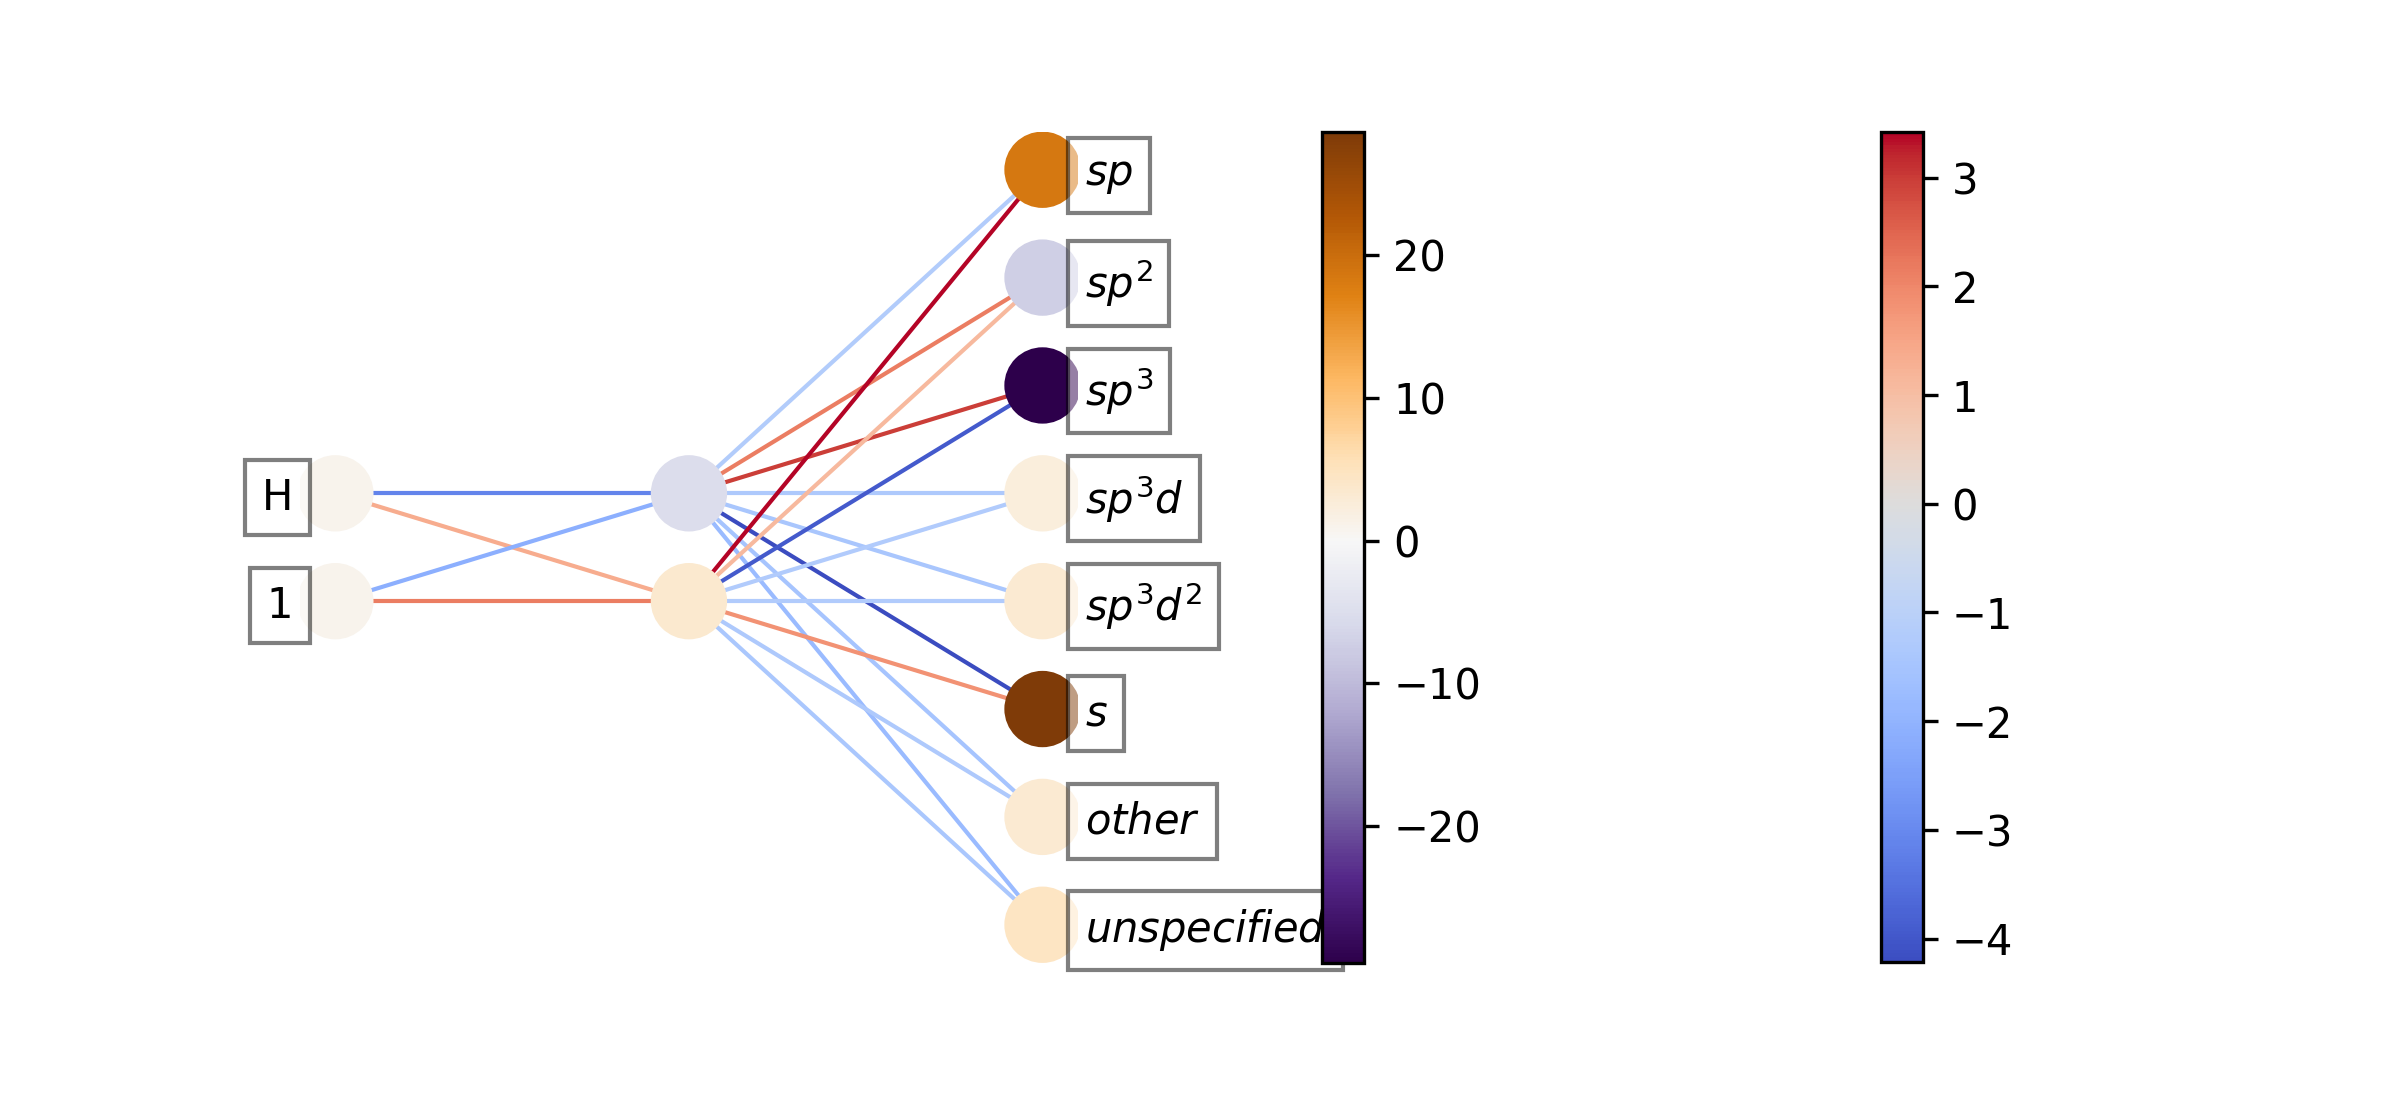

For a hydrogen with a single bond, the result should be $s$, sincethe single $1s$ orbital does not hybridize.
    As can be seen in the network the strongest influence (highest weight) between the input and the hidden layer is beween the
    atom type featuization ('H') and the first hidden neuron. Since the weight is negative the resulting neuron value is also negative.
    The second hidden neuron has a positive value, since both active input neurons are conencted via a positive weight.
    The output node with the highest output value will be the one, which is connected to the first (negative) hidden note with a negive weight
    and with the second hidden note via a positive weight.
    As can be seen in the graph representation, this is indeed the case for the last output noden, wich encodes the $s$ hybridization.
    

For Atom 'C' with 3 connections

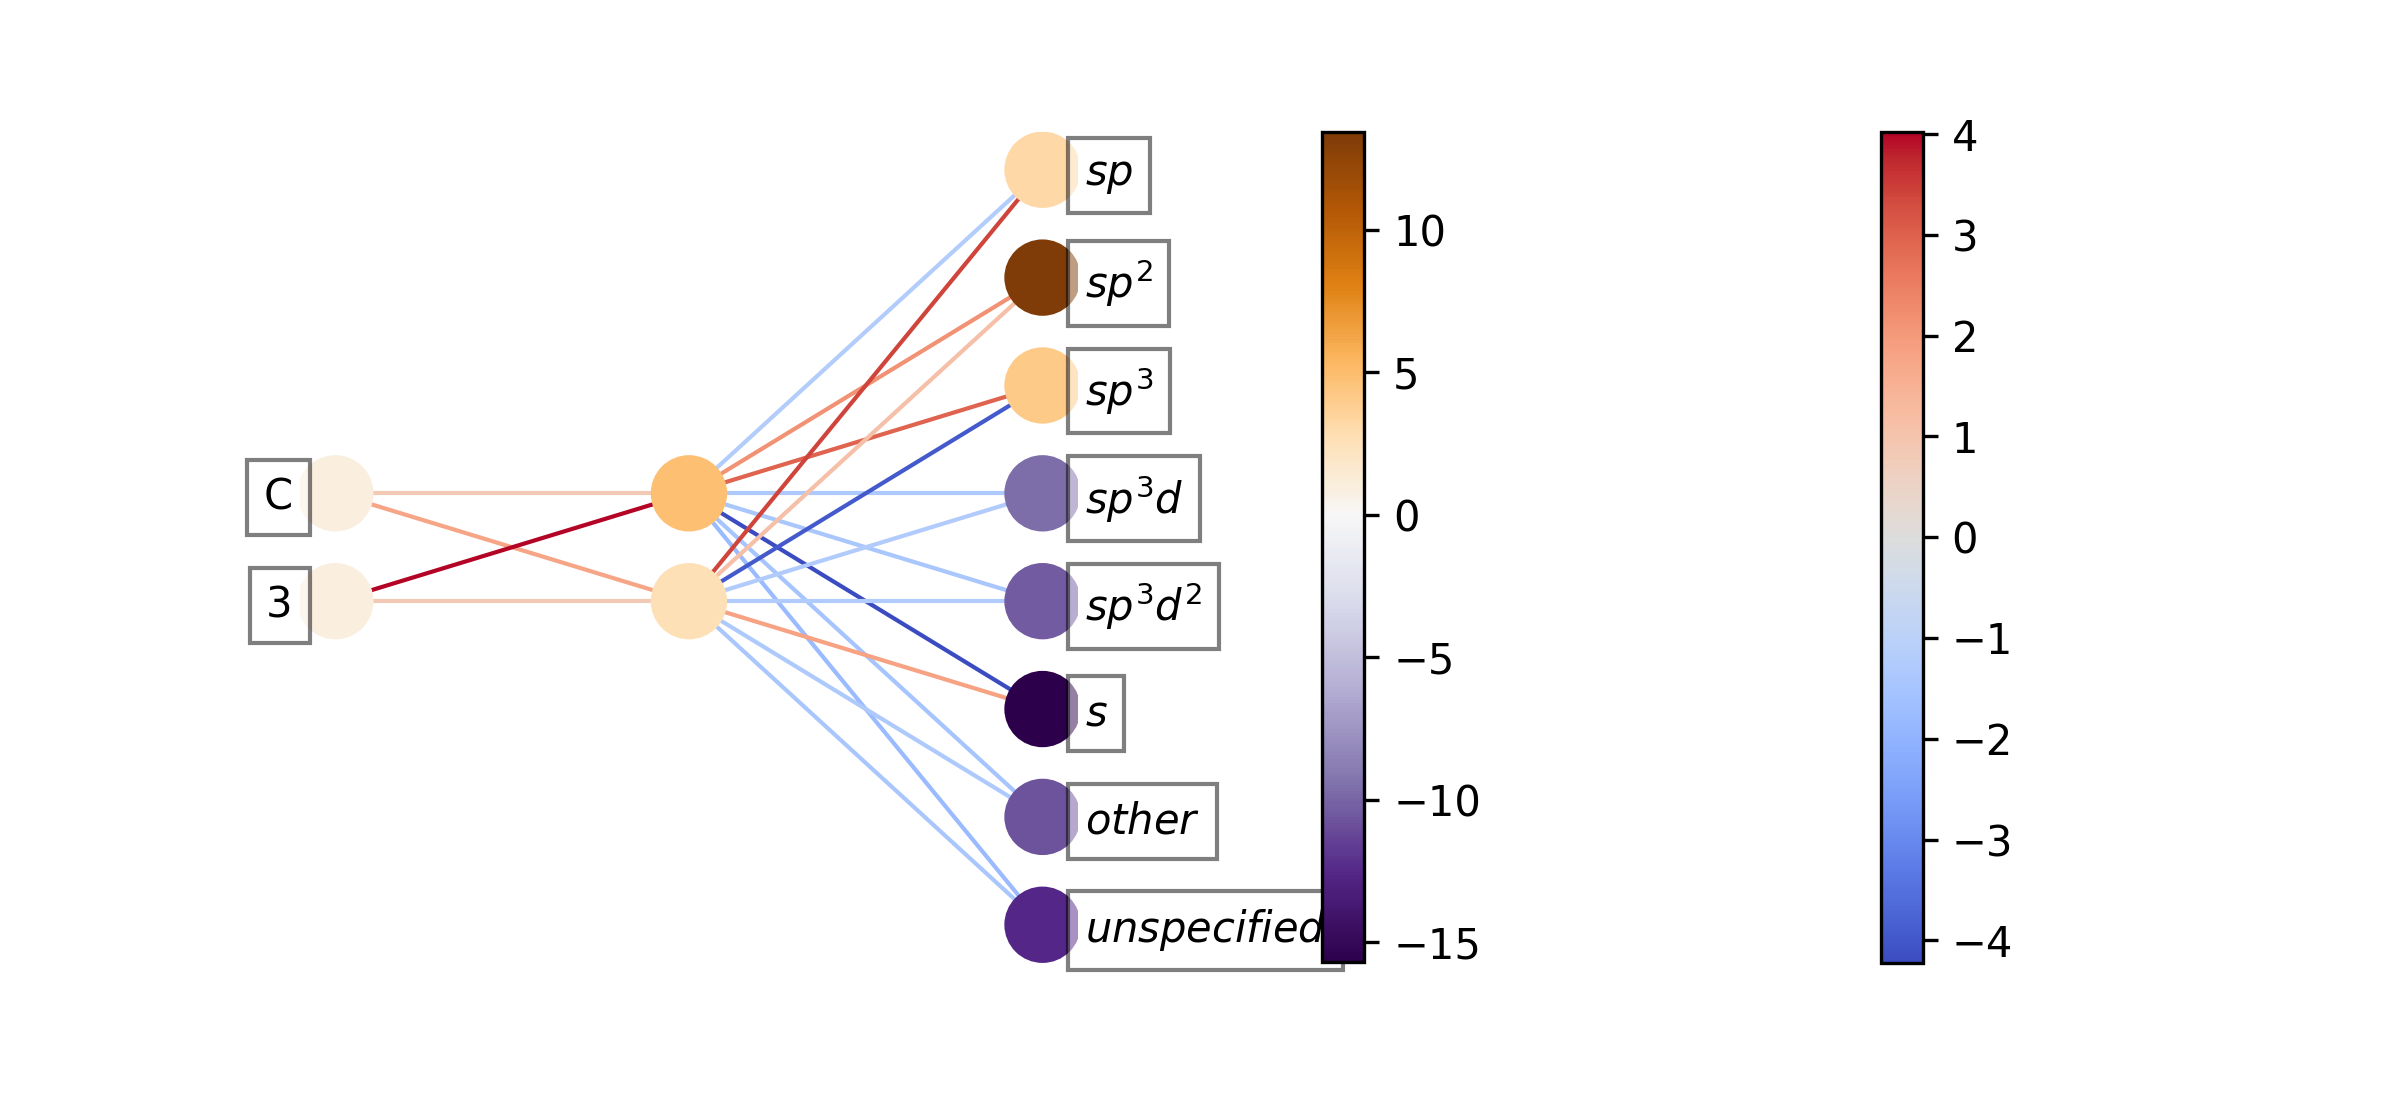

A carbon atom with 3 bonding partners is also predicted to be $sp^2$ hybridized.
    This prediction results from a positive weighted connecten between the atom type input and
    the first hidden neuron, and negative weighted connection beween the degree input and the second hidden neuron.
    Both weights are of similar absolute value, resulting in a similar hidden neurons with opposite signs,
    similar the the previous example, resulting in the same output.
    

For Atom 'O' with 2 connections

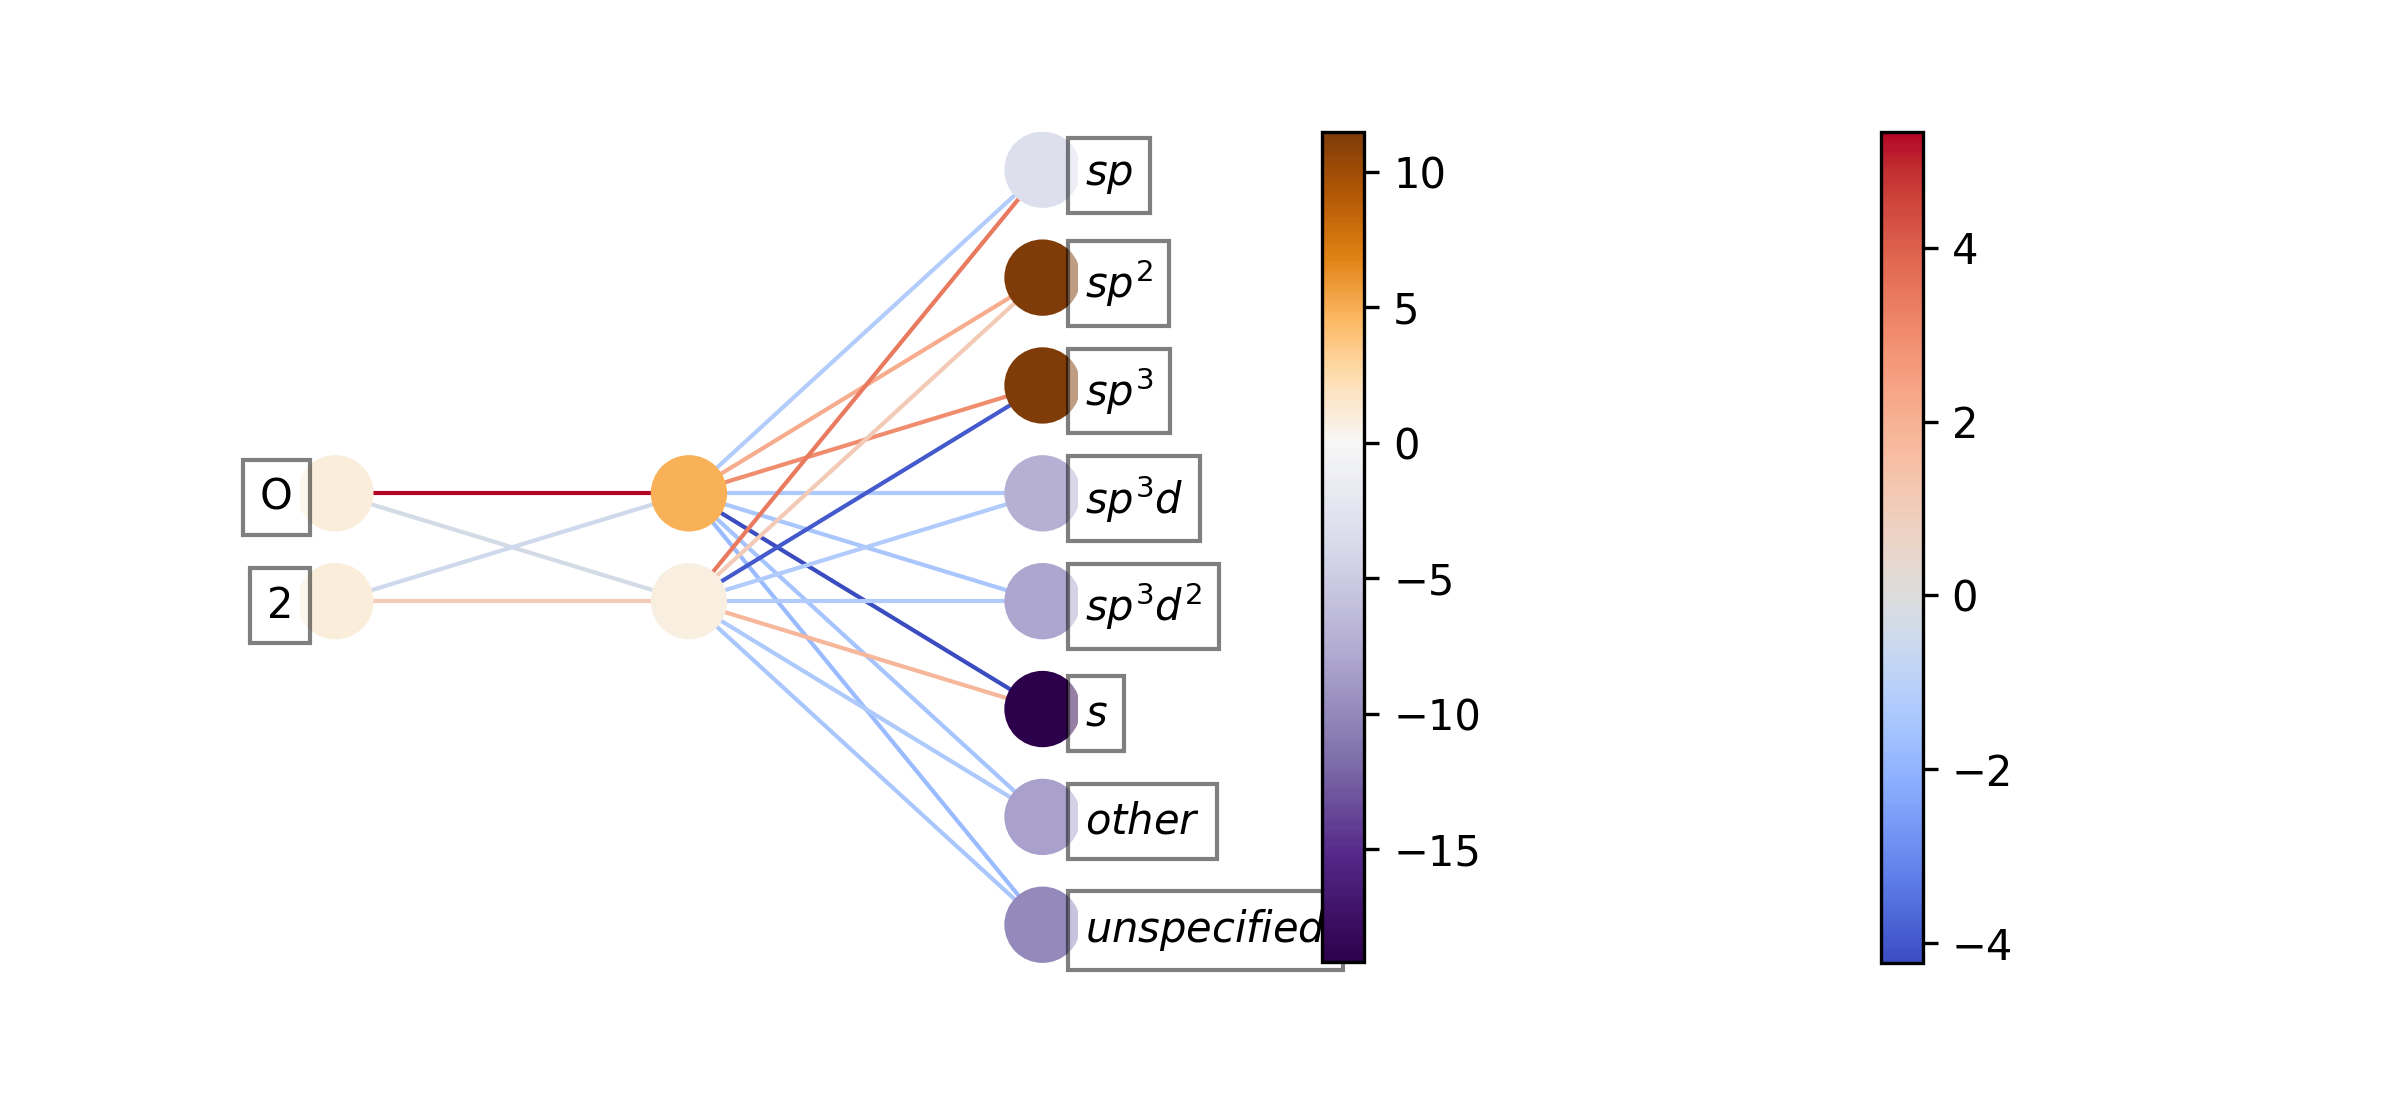

Fnally, oxigen atoms with 2 bonding partners are predicted to be $sp^3$ hybridized.
    This is a result from a strong negative connection from atom type input to second hidden node.
    All other conenctions are relativly weak, resulting again in a similar distribution in values
    in the hidden layers as in the previous $sp^3$ hybridized atoms and thus the same output.
    In this case this prediction is wrong, since one op the $p$-orbitals is integrated into the $\pi$-orbital of the connected phenyl ring.
    But since the model is not aware of any neigbouring atoms or systems, it cannot take into account any delocalization effects.
    

For Atom 'N' with 3 connections

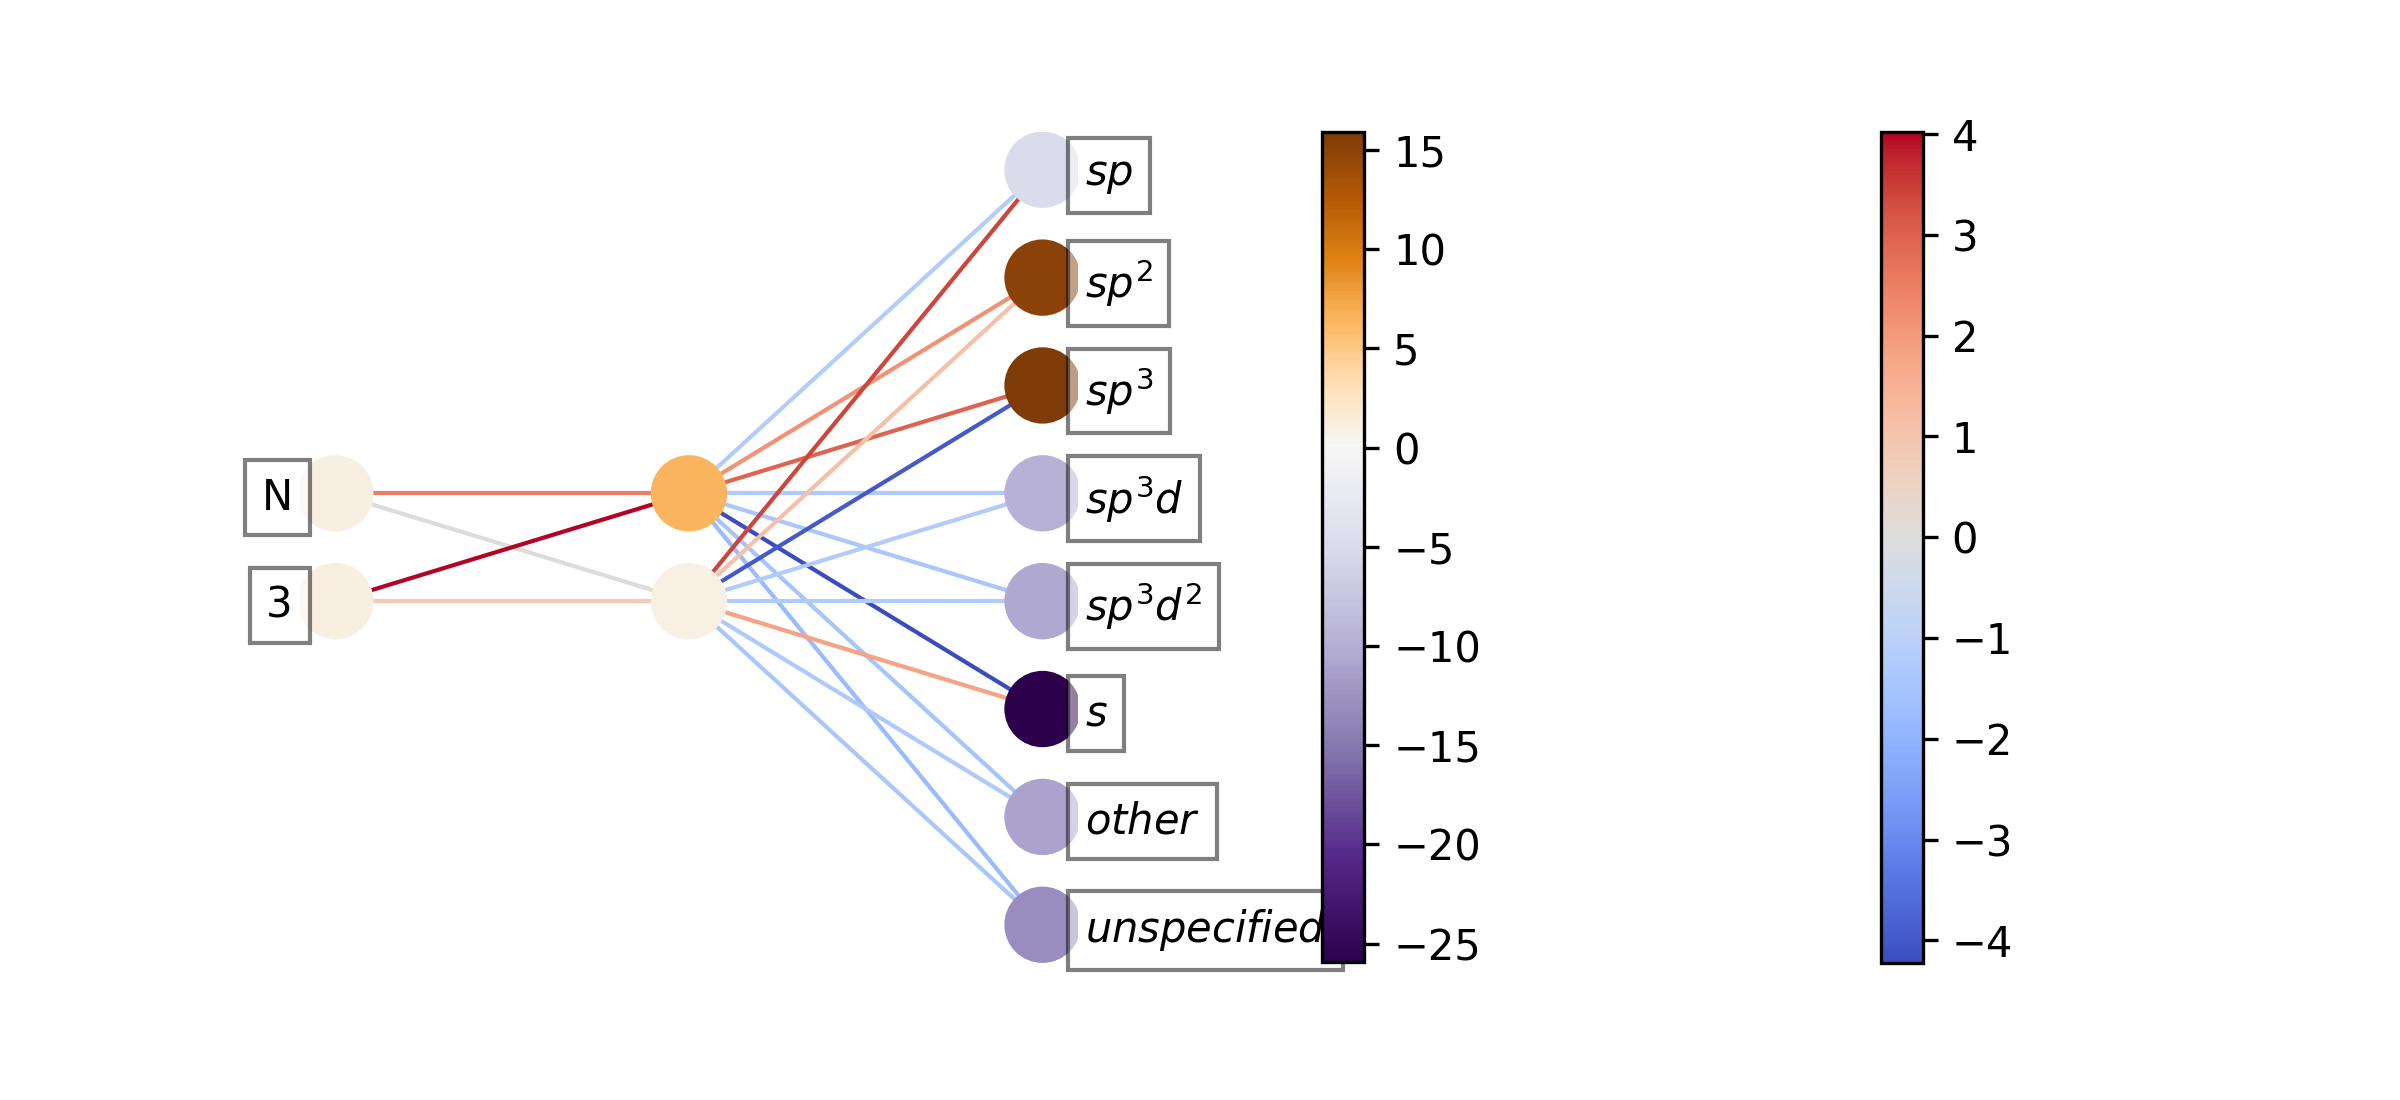

A nitrogen atom with 3 bonding partners is predicted to be $sp^3$ hybridized.
    In contrast to the previous inputs, here both inputs have a strong negative connection to the second hidden 
    neuron and only weak (positive and negative) connections to the fist hidden node.
    As a result the first hidden node is only weakly positive and the second node strogly negative.
    The predicted output will be encoded by the node which has the strongest negative connection to the second hidden node,
    which is indeed the $sp^3$-node. 
    

For Atom 'O' with 1 connections

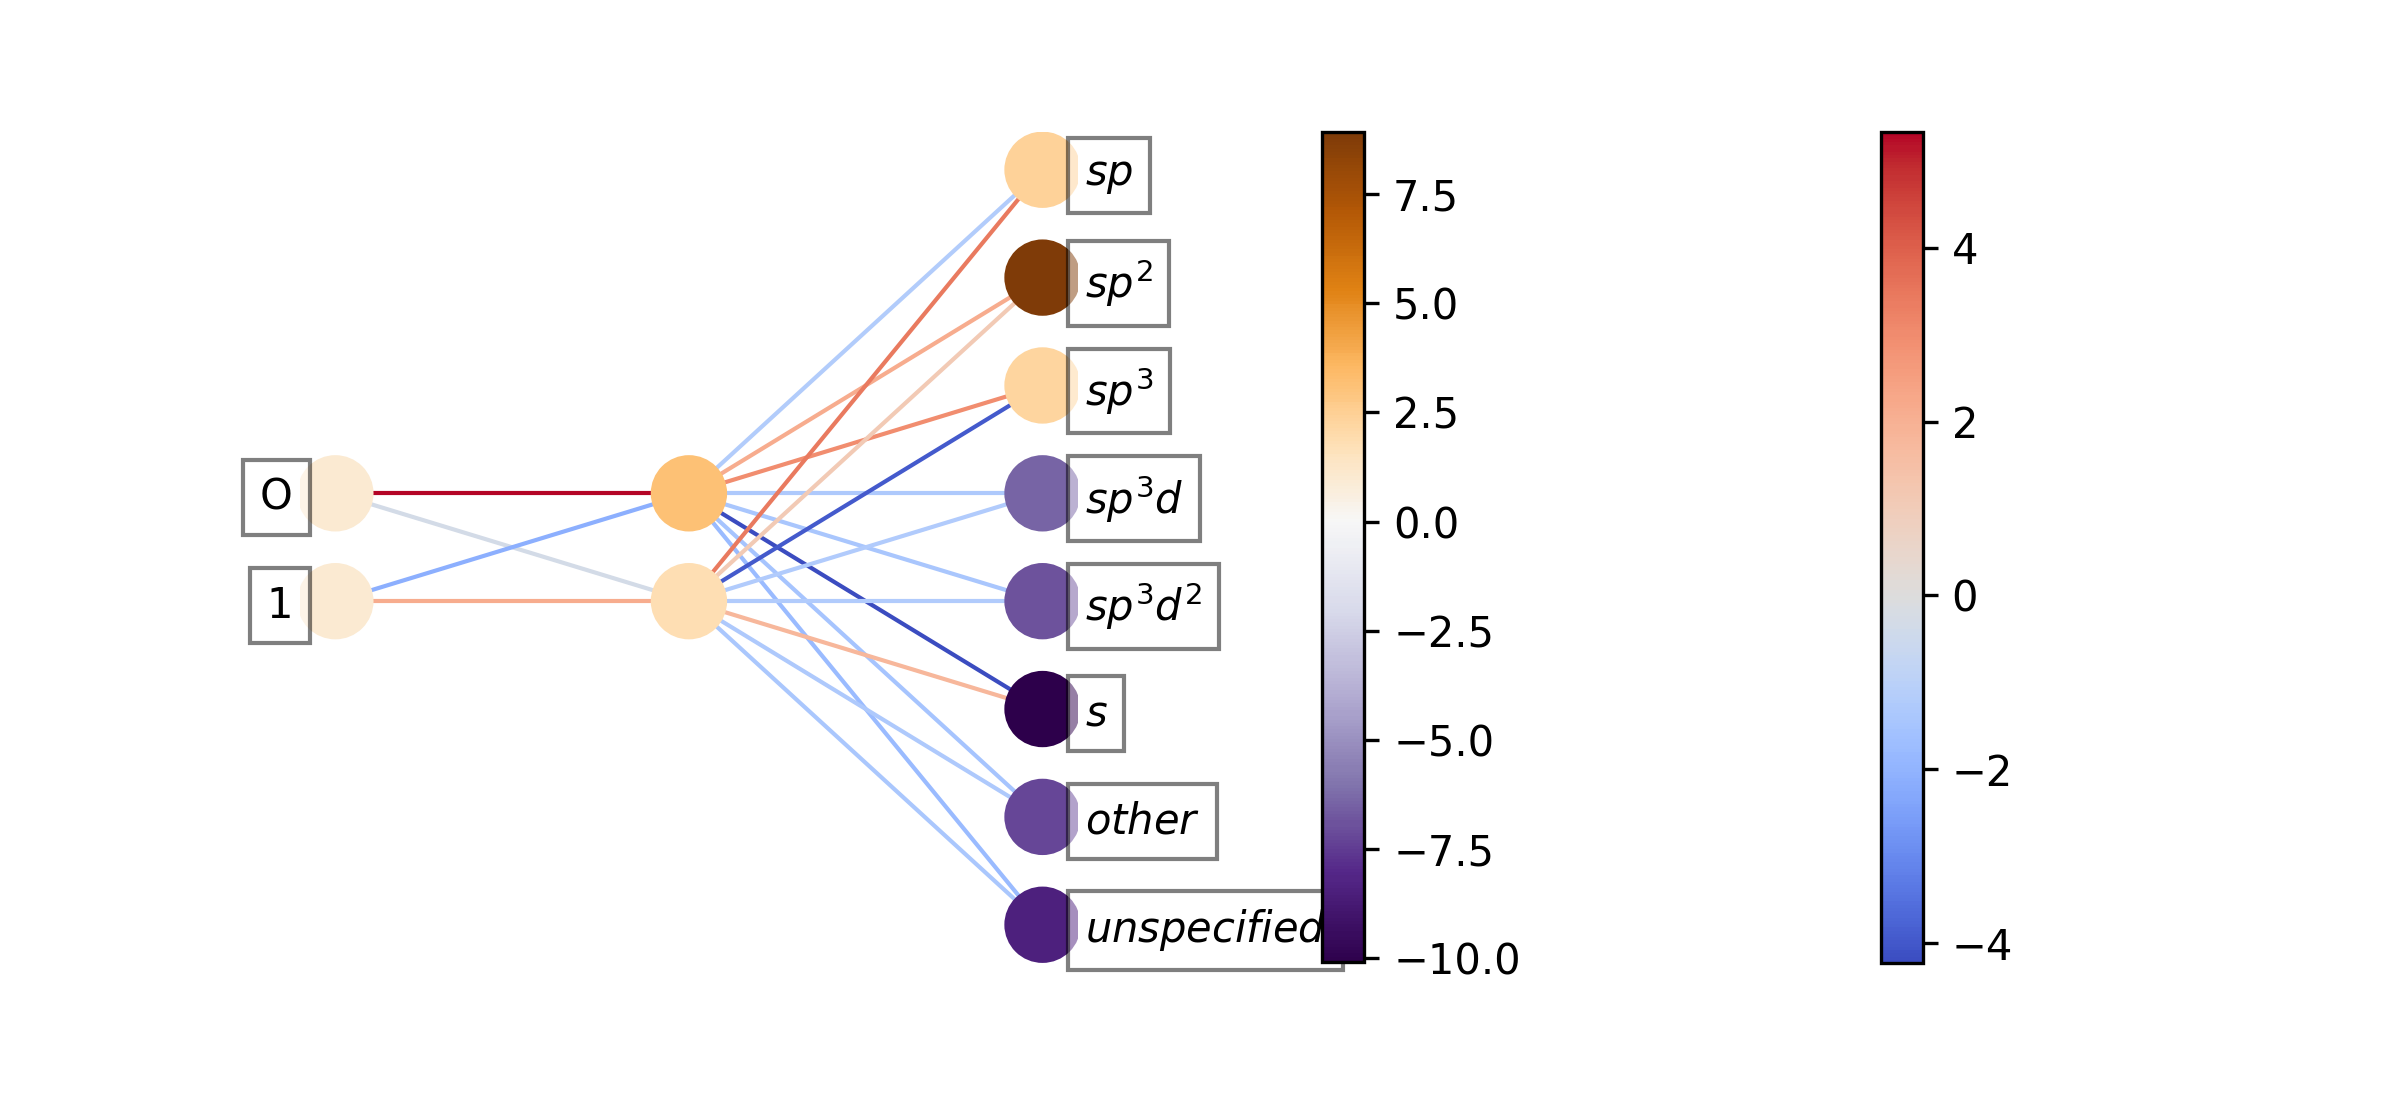

An oxigen atom with a single bonding partners is predicted to be $sp^2$ hybridized.
    This prediction results strong negative weighted connecten between the atom type input and
    the second hidden neuron, and posive weighted connection beween the degree input and the number input, and the first hidden neuron.
    Which results in a similar hidden neurons with opposite signs.
    As a result the output node with the highest value is the one with has a strong posive to the first and a
    strong negative connection to the second hidden node, which is the case for the $sp^2$-output.
    

For Atom 'C' with 4 connections

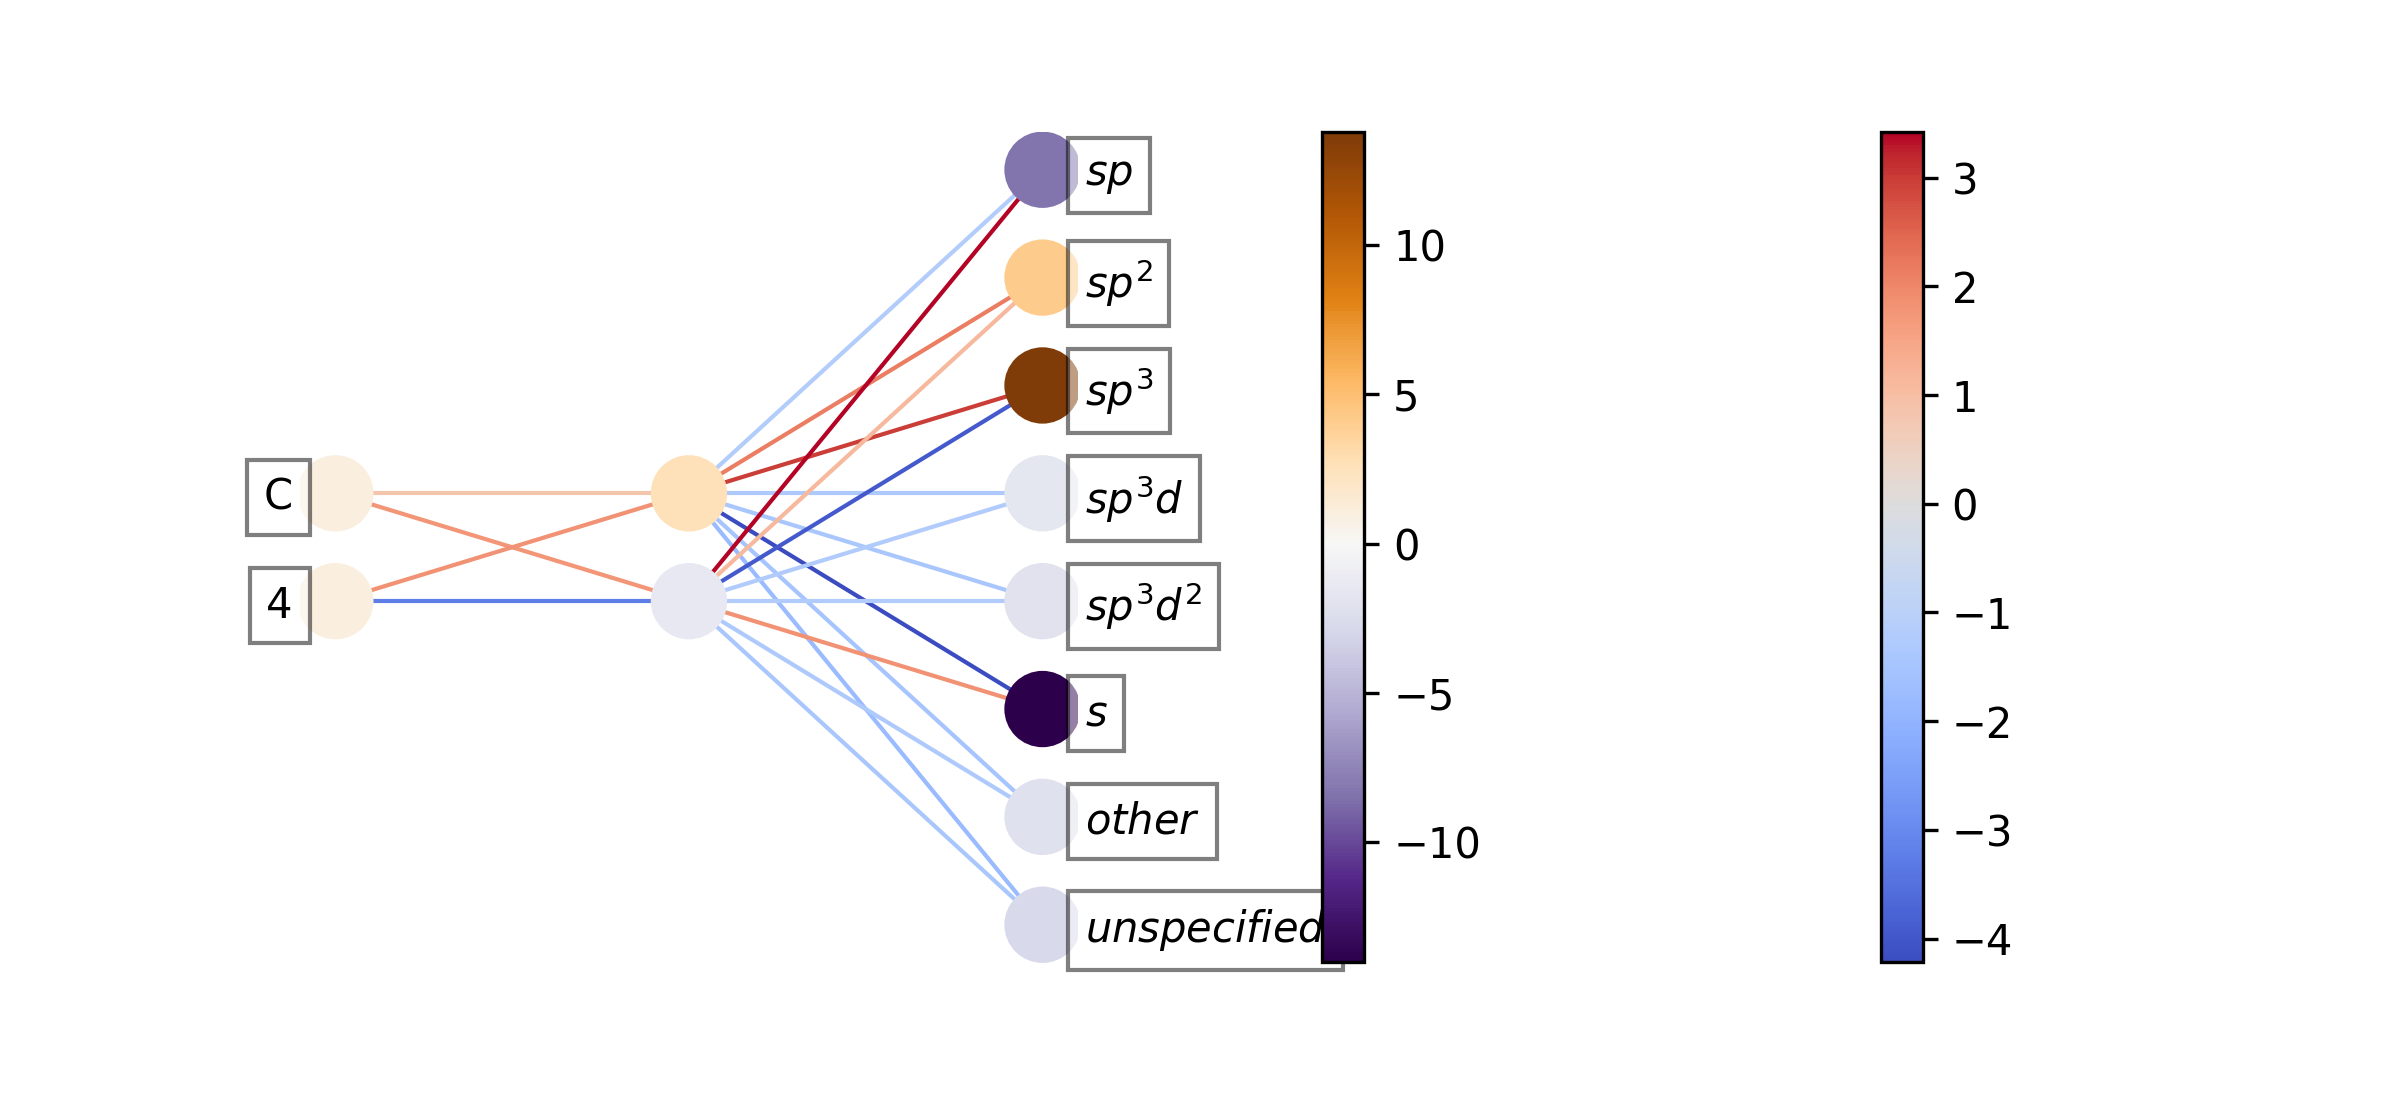

Similary a carbon with 4 bonding partners is also predicted to be $sp^3$ hybridized.
    In this case the atom type input has only a weak influence (low weights),
    but the degree is strongly conencted to both hidden nodes.
    This makes sence, since in organic chemsitry, which makes up the training data, usually atoms with for connections
    (carbon in most cases) is $sp^3$ hybridized.
    Now both hidden neurons have negative values. As a result the output is determinded by
    the most negative conenctions beween hidden neurons and output.
    

In [29]:
interpretations={
    ('H','1'):
    """For a hydrogen with a single bond, the result should be $s$, sincethe single $1s$ orbital does not hybridize.
    As can be seen in the network the strongest influence (highest weight) between the input and the hidden layer is beween the
    atom type featuization ('H') and the first hidden neuron. Since the weight is negative the resulting neuron value is also negative.
    The second hidden neuron has a positive value, since both active input neurons are conencted via a positive weight.
    The output node with the highest output value will be the one, which is connected to the first (negative) hidden note with a negive weight
    and with the second hidden note via a positive weight.
    As can be seen in the graph representation, this is indeed the case for the last output noden, wich encodes the $s$ hybridization.
    """,
('O','1'):
    """An oxigen atom with a single bonding partners is predicted to be $sp^2$ hybridized.
    This prediction results strong negative weighted connecten between the atom type input and
    the second hidden neuron, and posive weighted connection beween the degree input and the number input, and the first hidden neuron.
    Which results in a similar hidden neurons with opposite signs.
    As a result the output node with the highest value is the one with has a strong posive to the first and a
    strong negative connection to the second hidden node, which is the case for the $sp^2$-output.
    """,
('C','3'):
    """A carbon atom with 3 bonding partners is also predicted to be $sp^2$ hybridized.
    This prediction results from a positive weighted connecten between the atom type input and
    the first hidden neuron, and negative weighted connection beween the degree input and the second hidden neuron.
    Both weights are of similar absolute value, resulting in a similar hidden neurons with opposite signs,
    similar the the previous example, resulting in the same output.
    """,
('N','3'):
    """A nitrogen atom with 3 bonding partners is predicted to be $sp^3$ hybridized.
    In contrast to the previous inputs, here both inputs have a strong negative connection to the second hidden 
    neuron and only weak (positive and negative) connections to the fist hidden node.
    As a result the first hidden node is only weakly positive and the second node strogly negative.
    The predicted output will be encoded by the node which has the strongest negative connection to the second hidden node,
    which is indeed the $sp^3$-node. 
    """,
('C','4'):
    """Similary a carbon with 4 bonding partners is also predicted to be $sp^3$ hybridized.
    In this case the atom type input has only a weak influence (low weights),
    but the degree is strongly conencted to both hidden nodes.
    This makes sence, since in organic chemsitry, which makes up the training data, usually atoms with for connections
    (carbon in most cases) is $sp^3$ hybridized.
    Now both hidden neurons have negative values. As a result the output is determinded by
    the most negative conenctions beween hidden neurons and output.
    """,
('O','2'):
    """Fnally, oxigen atoms with 2 bonding partners are predicted to be $sp^3$ hybridized.
    This is a result from a strong negative connection from atom type input to second hidden node.
    All other conenctions are relativly weak, resulting again in a similar distribution in values
    in the hidden layers as in the previous $sp^3$ hybridized atoms and thus the same output.
    In this case this prediction is wrong, since one op the $p$-orbitals is integrated into the $\pi$-orbital of the connected phenyl ring.
    But since the model is not aware of any neigbouring atoms or systems, it cannot take into account any delocalization effects.
    """,
}
for i in range(len(possible_input_arrays)):
    x_array=possible_input_arrays[i].astype(bool)
    atom_desc = feature_desc[x_array]
    display(md("For Atom '{}' with {} connections".format(atom_desc[0],atom_desc[1])))
    
    sf=os.path.join(data["files"]['plot_dir'],"detailed_hybridization_pred_{}_{}.png".format(atom_desc[0],atom_desc[1]))
    if not os.path.exists(sf) or REDRAW:
        x=possible_input_tensors[i]
        

        labels=[]
        layer=[]

        activation1=model.nn1(x)
        activation2=model.nn2(activation1)



        layer.append(x_array.shape[0])
        labels.extend(feature_desc)

        needed = x_array>0 
        reduces_weights_1 = weights1.copy()
        reduces_weights_1[:,~needed]=0

        layer.append(reduces_weights_1.shape[0])
        labels.extend([None]*reduces_weights_1.shape[0])

        reduces_weights_2 = weights2.copy()

        layer.append(reduces_weights_2.shape[0])
        labels.extend(short_hybrid)

        plot_fcnn(layer,
                  weights=[reduces_weights_1,reduces_weights_2],
                  input_labels=labels,
                  hide_loose=True,
                  show_bar=True,
                  input_array=x_array,
                  nodes_cmap=plt.cm.PuOr_r,
                  save=sf,
                 )
    display(Image(sf,width=DEFAULT_IMG_PLOT_WIDTH))
    display(md(interpretations.get((atom_desc[0],atom_desc[1]),"**missing description**")))

All oher wrong predictions also result from the same reason: Atoms with non-binding free electron pairs, neigbouring atoms with $p$-orbitals ($\pi$-orbitals), contibute one of their $p$ orbitals to the system, resulting in another hybridization. This is nothing the model can learn, since atoms have no information about neigbouring atom; for this graph convolution comes into play.

In [30]:
try:
    loader.test_dataloader()
except:
    loader.setup()
    

subgroups=['c[N:1]',#N on phenyl
           'c[O:1]',#O on phenyl
           'C=C[O:1]',#Enol ether
           '[o:1]',# aromatic oxigen
           '[n:1]',# aromatic nitrogen
           '[s:1]',# aromatic sulfur
           'C[N:1](=O)[O-]',#nitro
           'CO[N:1](=O)[O-]',#Nitrate ester
           'C(=O)[O:1]',#carbonly
           'C(=O)[N:1]',#amid
           'C(=N)[O:1]',#carboximidate
           'C#C[O:1]',#alkyinether
           'C#C[N:1]',#alkyinamin
           'P(=O)[O:1]',#phosphoric acid
           '[N:1]C(=N)N',#Guanidines 
           'N[N:1](=O)[O-]',#nitramines
          ]
sgd=[]
for s in subgroups:
    ind_map = {}
    qmol = Chem.MolFromSmarts(s) 
    for atom in qmol.GetAtoms() :
        map_num = atom.GetAtomMapNum()
        if map_num:
            ind_map[map_num-1] = atom.GetIdx()
    map_list = np.array([ind_map[x] for x in sorted(ind_map)])
    sgd.append((qmol,map_list))
    
for _loader in [loader.test_dataloader(),loader.val_dataloader(),loader.train_dataloader()]:
    for d in _loader:
        pred=model(d)
        bad_pred=pred.argmax(1)!=d.y.argmax(1)
        for batch in d.batch[bad_pred].unique():
            indices=d.batch == batch
            
            graph=d.mol_graph[batch]
            l_true = short_hybrid[d.y[indices].detach().numpy().argmax(1)].astype(np.object)
            l_pred = short_hybrid[pred[indices].detach().numpy().argmax(1)].astype(np.object)
            
            
            wrong_l=l_true!=l_pred
            node_color=np.array(['#1f78b4']*len(graph))
            node_color[wrong_l]="red"
            l=l_true.copy()
            l[wrong_l]=l_pred[wrong_l]+"("+l_true[wrong_l]+")"
            
            mol=graph.molecule.mol
            found=False
            for sg in sgd:
                if found:
                    break
                #display(sg[0])
                for match in mol.GetSubstructMatches( sg[0] ):
                    match=np.array(match)
                    ##print(sg[1])
                    mas = match[sg[1]]
                    if any(np.where(wrong_l)[0]==mas):
                        found=True
                        break
                        
            if not found:
                display(graph.molecule)
                f = graph.get_fig(labels=l.tolist(),node_color=node_color)
                plt.show()
                plt.close()
                display(Chem.MolToSmiles(graph.molecule.mol))
            #l = short_hybrid[pred[indices].detach().numpy().argmax(1)].tolist()
            #f = graph.get_fig(labels=l)
            #plt.show()
            #plt.close()
        
    
    
    

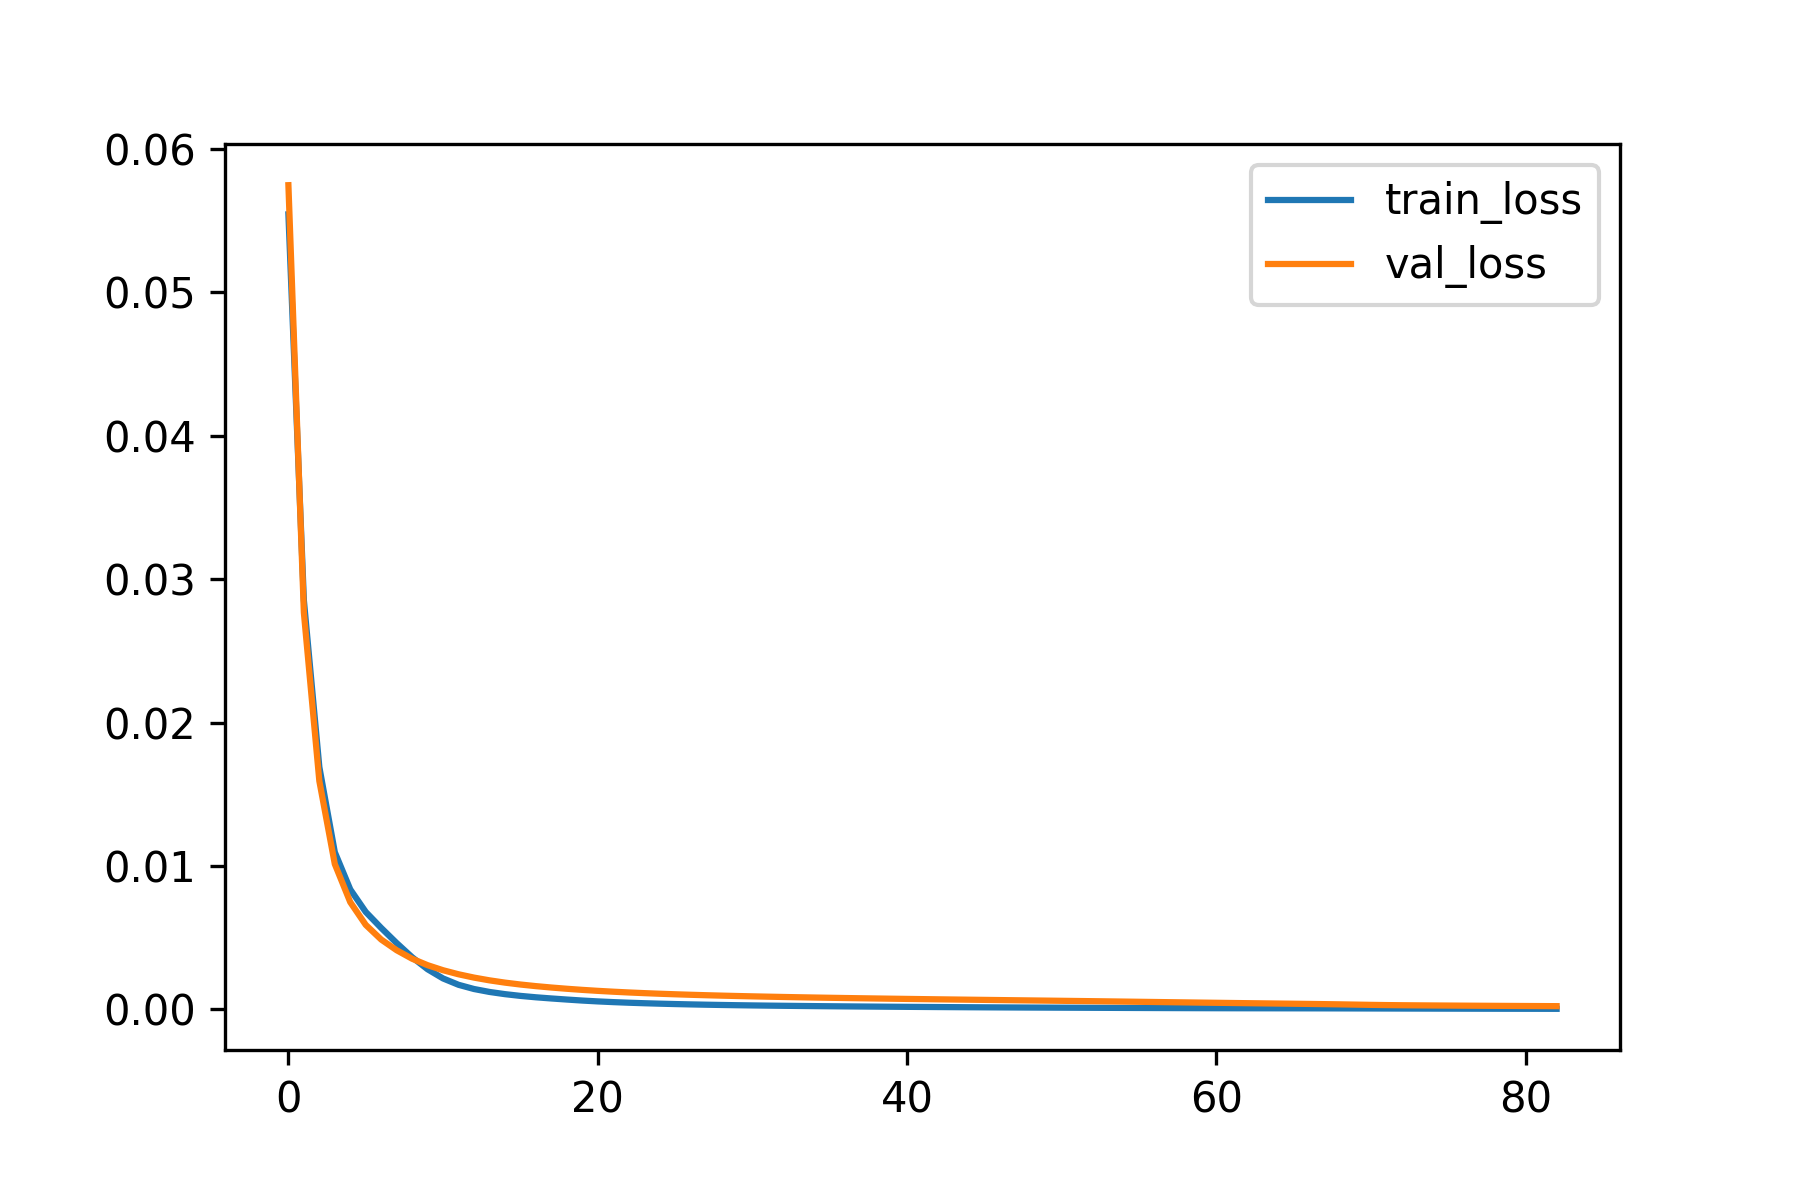

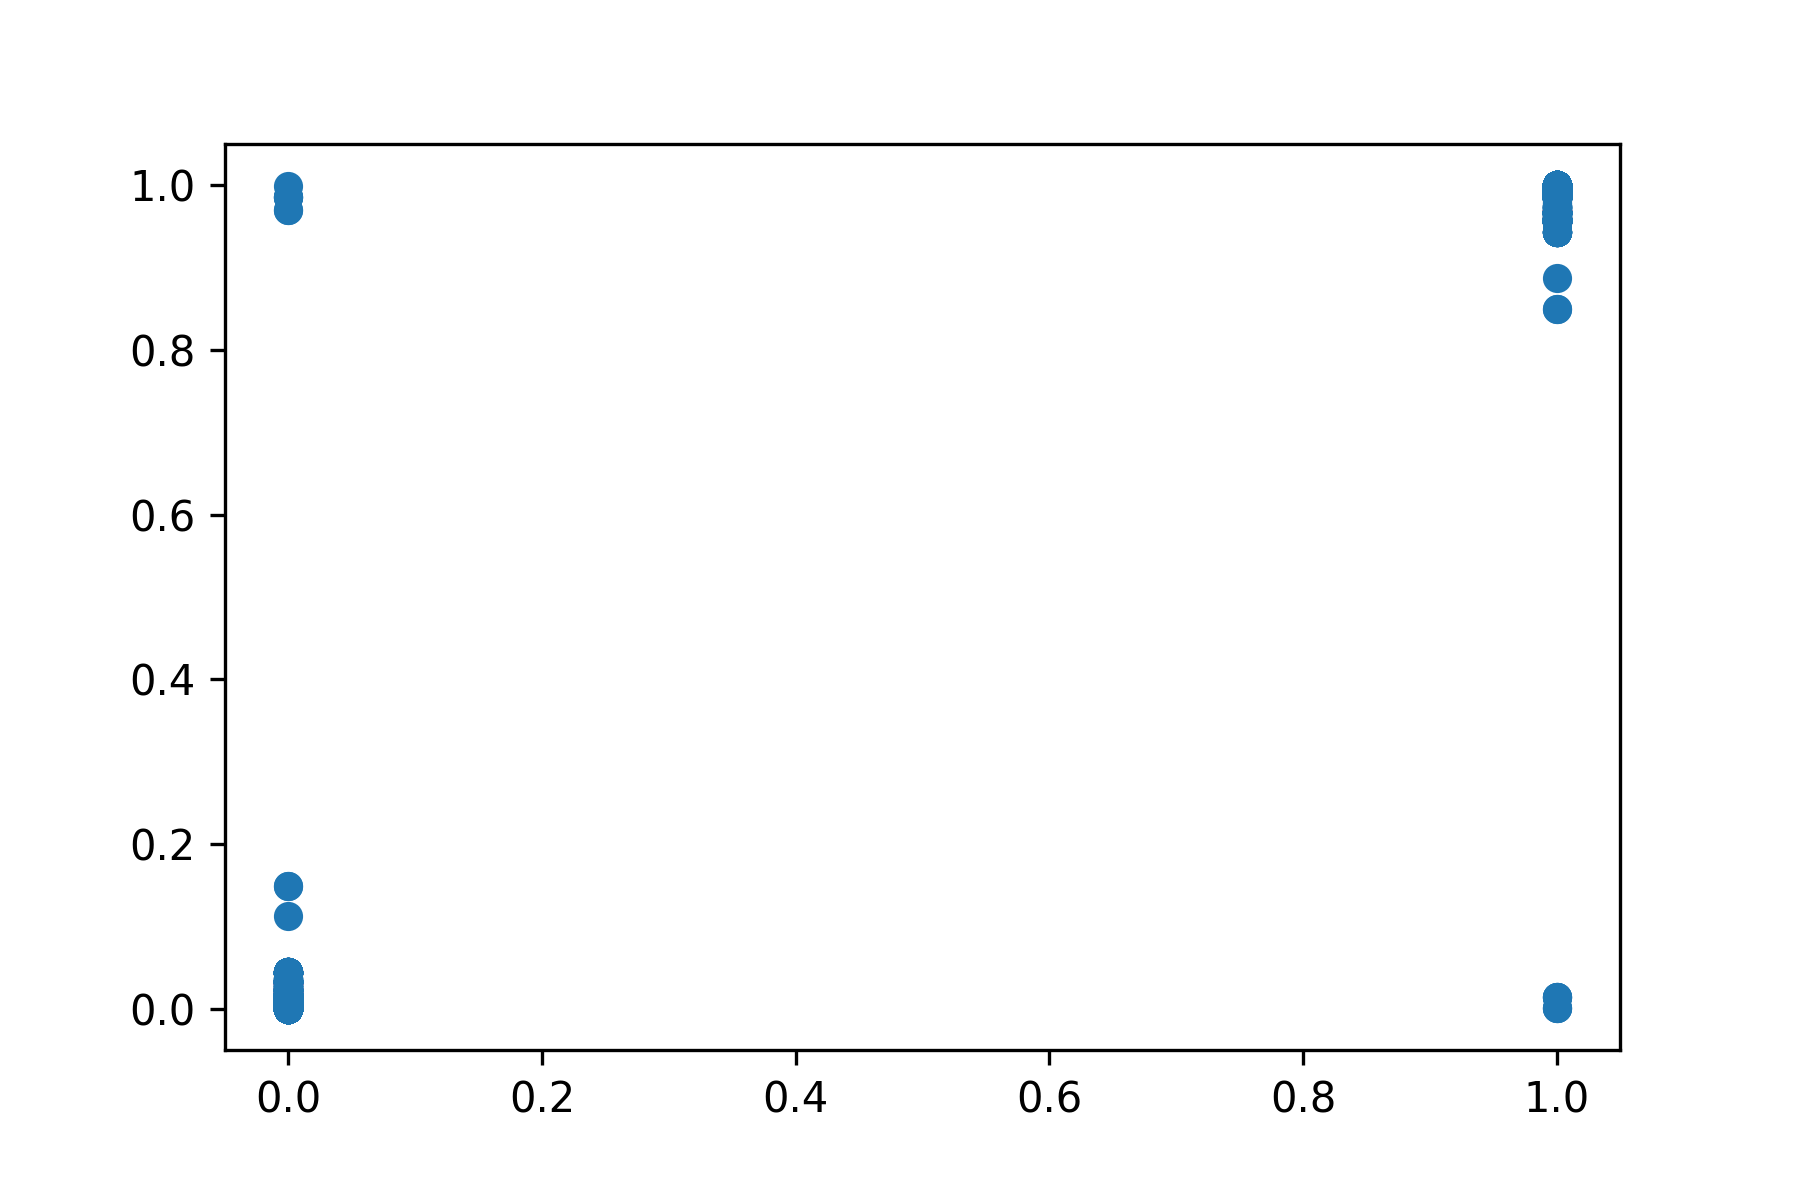

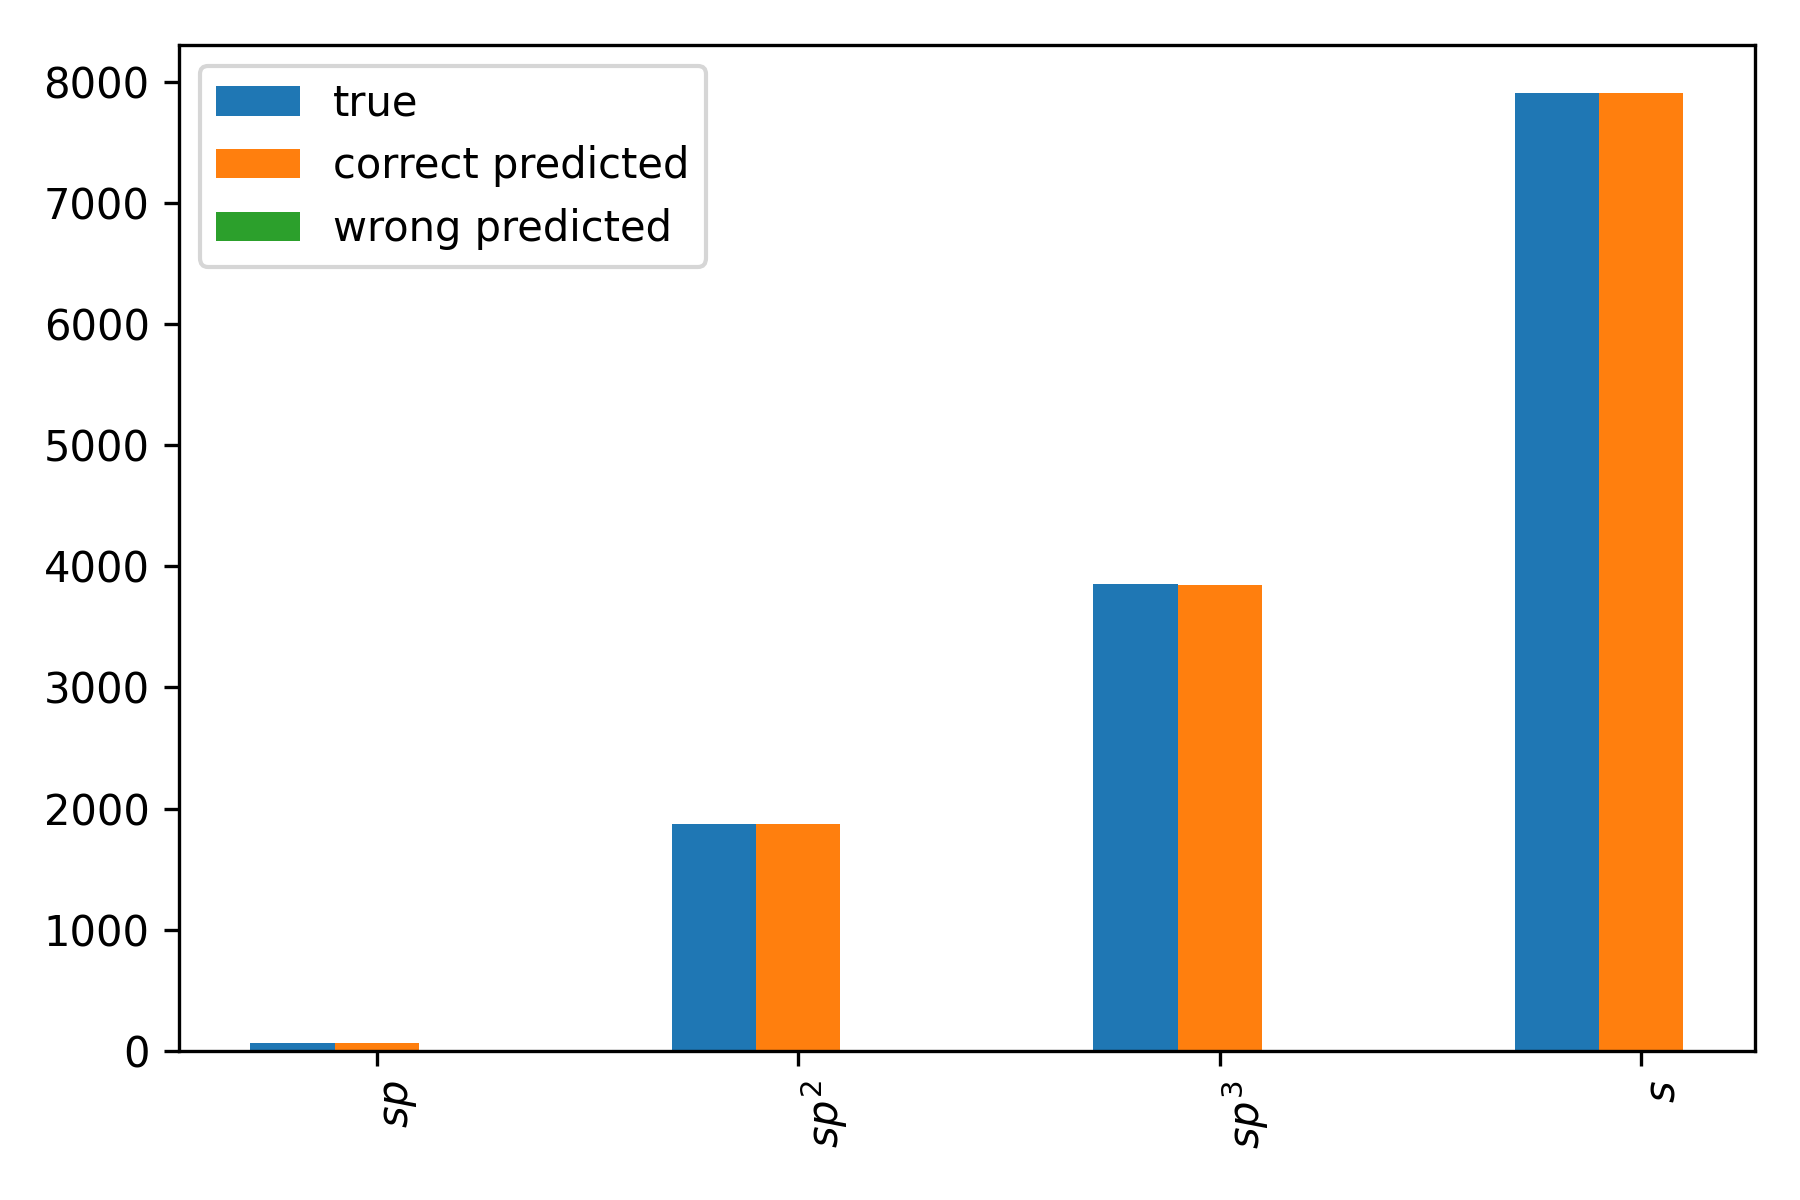

In [31]:
from molNet.featurizer.atom_featurizer import atom_hybridization_one_hot,atom_degree_one_hot

featurizer=c_atom_symbol_featurizer+atom_degree_one_hot
class HybridizationFromTypeGCModel(pl.LightningModule):
    def __init__(self,in_size,name="none"):
        super().__init__()
        self.save_hyperparameters()
        out_size=len(atom_hybridization_one_hot)
        
        med_size=2
        graph_out=4
        
        self.nn1 = torch.nn.Linear(in_size, med_size,bias=False)
        self.nn2 = torch.nn.Linear(med_size, out_size,bias=False)
        
        self.gc = GCNConv(out_size+in_size,graph_out,normalize=False)
        
        
        
        self.nn3 = torch.nn.Linear(graph_out+out_size, out_size,bias=False)
        
        
        
        self.softmax = torch.nn.Softmax(dim=1)
        self.lr = 1e-2
        
        self.lossf=F.binary_cross_entropy#torch.nn.BCEWithLogitsLoss()#

    def unpacked_forward(self, feats, edges, batch,graph_features):
        in_feats=feats
        feats =self.nn1(in_feats)
        feats =self.nn2(feats)
        feats = self.softmax(feats)
        
        gcfeats =self.gc(torch.cat([in_feats,feats],1),edges,edge_weight = torch.ones((edges.size(1), ),device=edges.device))
        feats =self.nn3(torch.cat([gcfeats,feats],1))
        #print(gcfeats.shape,feats.shape)
        #feats =self.nn2(torch.cat([gcfeats,feats],1))
        feats = self.softmax(feats)
        return feats

    def forward(self,batch):
        return self.unpacked_forward(feats=batch.x,edges=batch.edge_index,batch=batch.batch,graph_features=batch.graph_features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss =  self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        #print(y_hat[0],batch.y[0],loss)
        self.log('val_loss', loss)
        return loss
    
    def test_step(self,batch, *args, **kwargs):
        y_hat=self(batch)
        loss = self.lossf(y_hat, batch.y)#mF.rell1_loss(y_hat, batch.y)*100
        self.log('test_loss', loss)
        return loss
            
loader = PytorchGeomMolGraphFromDfLoader(dataset,smiles_column='SMILES',additional_data=['name'],#"all",
                                     y_properties=["hybridization"],
                                     seed=1,
                                     to_graph_params={
                                         "atom_featurizer":featurizer,
                                         "with_mol_graph":True
                                     },
                                    batch_size=32,#num_workers=4
                                    follow_batch=["y"]
                                    )
model = HybridizationFromTypeGCModel(in_size=len(featurizer))

short_hybrid = np.array(["$"+s.split()[1].lower().replace("2","^2").replace("3","^3")+"$" for s in atom_hybridization_one_hot.describe_features()])


model,data = default_model_run("HybridizationFromTypeGCModel",model,loader,
                  force_run=REMODEL,
                  #force_test_data_reload=True,
                #min_epochs=25,
                               early_stopping=True,
                               #max_epochs=50,
                               detect_lr=False,
                categories=short_hybrid.tolist(),
)
test_data=data['test_data']
test_batch=data['test_batch']

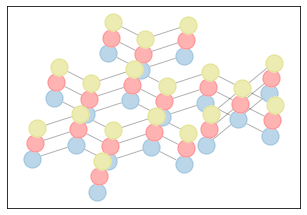

In [59]:
pos=test_data.mol_graph.calc_position(norm=True)
pos_list = np.array(list(pos.values()))

pos_list=pos_list-[pos_list[:,0].max()/2,pos_list[:,1].max()/2]

tunred_pos=pos_list.copy()
tunred_pos[:,0]=tunred_pos[:,0]+tunred_pos[:,1]*0.2

tunred_pos=tunred_pos/[1,1.2]


fig = plt.figure(figsize=(
            0.1 + 5 * (tunred_pos[:, 0].max()-tunred_pos[:, 0].min()),
            0.1 + 5 * (tunred_pos[:, 1].max()-tunred_pos[:, 1].min()),
        ))

graph_draw_kwargs={
    "arrowstyle":"-",
    "with_labels":None,
    "alpha":0.3,
}

#nx.draw_networkx_edges(test_data.mol_graph,{i:tunred_pos[i] for i in range(pos_list.shape[0])},**graph_draw_kwargs)
#nx.draw_networkx_nodes(test_data.mol_graph,{i:tunred_pos[i] for i in range(pos_list.shape[0])},**graph_draw_kwargs)
nx.draw_networkx_nodes(test_data.mol_graph,{i:tunred_pos[i] for i in range(pos_list.shape[0])},node_color="w")
nx.draw_networkx(test_data.mol_graph,{i:tunred_pos[i] for i in range(pos_list.shape[0])},**graph_draw_kwargs)

#nx.draw_networkx(test_data.mol_graph,pos,**graph_draw_kwargs)
sp=tunred_pos+[0.01,0.08]
#nx.draw_networkx_edges(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="r",**graph_draw_kwargs)
nx.draw_networkx_nodes(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="w")
nx.draw_networkx(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="r",**graph_draw_kwargs)

sp=sp+[0.01,0.08]
#nx.draw_networkx_edges(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="y",**graph_draw_kwargs)
nx.draw_networkx_nodes(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="w")
nx.draw_networkx(test_data.mol_graph,{i:sp[i] for i in range(sp.shape[0])},node_color="y",**graph_draw_kwargs)
plt.show()

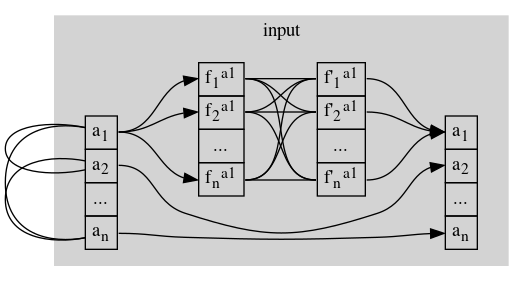

In [409]:
from graphviz import Digraph,Graph

pos=test_data.mol_graph.calc_position(norm=True)
pos_list = np.array(list(pos.values()))



g = Digraph("network", format='png', node_attr={'shape': 'record'},
            #engine="fdp"
           )
g.attr(rankdir='LR', size='8,5')
g.attr(compound='true')
g.attr(splines = "true" )



 
name="input_layer"
atoms=2
atoms_with_n = True
features=2
features_with_n = True


with g.subgraph(name="cluster_".format(name)) as sg:
    sg.attr(color='lightgray', style='filled')
    sg.attr(label="input")
    sg.attr(splines ="false")
    #sg.attr(compound='true')
        #sg.node('input', '<an>an|...|a2|{a1|{<fn>fn|...|f2|f1}}')

    table="""<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">"""
    row_string="""<tr><td port="a{}">a<sub>{}</sub></td></tr>"""
    for i in range(1,atoms+1):
        table+=row_string.format(i,i)
    if atoms_with_n:
        table+="""<tr><td>...</td></tr>"""
        table+=row_string.format("n","n")
    table+="</table>>"
    sg.node("atom_input", table,shape="none")
    
    
    table="""<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">"""
    row_string=""" <tr><td port="f{}">f<sub>{}</sub><sup>a1</sup></td></tr>"""
    for i in range(1,features+1):
        table+=row_string.format(i,i)
    if features_with_n:
        table+="""<tr><td>...</td></tr>"""
        table+=row_string.format("n","n")
    table+="</table>>"
    sg.node("feature_input",table,shape="none")
    
    
    table="""<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">"""
    row_string=""" <tr><td port="f{}">f'<sub>{}</sub><sup>a1</sup></td></tr>"""
    for i in range(1,features+1):
        table+=row_string.format(i,i)
    if features_with_n:
        table+="""<tr><td>...</td></tr>"""
        table+=row_string.format("n","n")
    table+="</table>>"
    sg.node("feature_output",table,shape="none")
    
    
    table="""<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">"""
    row_string="""<tr><td port="a{}">a<sub>{}</sub></td></tr>"""
    for i in range(1,atoms+1):
        table+=row_string.format(i,i)
    if atoms_with_n:
        table+="""<tr><td>...</td></tr>"""
        table+=row_string.format("n","n")
    table+="</table>>"
    sg.node("atom_output", table,shape="none")
    #with g.subgraph(name="cluster_fcc_layer") as sg:
    
    atom_l=list(range(1,atoms+1))
    if atoms_with_n:
        atom_l.append("n")
    
    feature_l=list(range(1,features+1))
    if atoms_with_n:
        feature_l.append("n")
    
    for i,s in enumerate(atom_l):
        for e in atom_l[i+1:]:
            sg.edge('atom_input:a{}'.format(s), 'atom_input:a{}'.format(e),dir="none")
    
    for f in feature_l:
        sg.edge('atom_input:a1', 'feature_input:f{}'.format(f))
    
    for f1 in feature_l:
        for f2 in feature_l:
                sg.edge('feature_input:f{}'.format(f1),'feature_output:f{}'.format(f2),arrowhead="none")
    
    
    for f in feature_l:
        sg.edge('feature_output:f{}'.format(f),'atom_output:a1')
        
    for a in atom_l[1:]:
        sg.edge('atom_input:a{}'.format(a),'atom_output:a{}'.format(a))
    
    

Image(g.render(view=True, cleanup=True))

In [ ]:
sg.node('input', label=
    """<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">
        <tr>
            <td colspan="2" port="an">a<sub>n</sub></td>
        </tr>
        <tr>
            <td colspan="2">...</td>
        </tr>
        <tr>
            <td colspan="2" port="a2">a<sub>2</sub></td>
        </tr>
        <tr>
            <td ROWSPAN="4"  port="a1">a1</sub></td>
            <td port="fn">a<sub>1</sub><sup>fn</sup></td>
        </tr>
        <tr>
            <td>...</td>
        </tr>
        <tr>
            <td port="f2">a<sub>1</sub><sup>f2</sup></td>
        </tr>
        <tr>
            <td port="f1">a<sub>1</sub><sup>f1</sup></td>
        </tr>
    </table>>""",shape="none"
          )

    sg.node('hidden', label=
    """<<table BORDER="0" CELLBORDER="1" CELLSPACING="0" CELLPADDING="4">
        <tr>
            <td colspan="2" port="an">a<sub>n</sub></td>
        </tr>
        <tr>
            <td colspan="2">...</td>
        </tr>
        <tr>
            <td colspan="2" port="a2">a2</td>
        </tr>
        <tr>
            <td port="fn">fn</td>
            <td ROWSPAN="4">a1</td>
        </tr>
        <tr>
            <td>...</td>
        </tr>
        <tr>
            <td port="f2">f2</td>
        </tr>
        <tr>
            <td port="f1">f1</td>
        </tr>
    </table>>""",shape="none"
          )


    #sg.node('hidden', r'an|...|a2|{{fn|...|f2|<f1>}|a1}')
    sg.edge('input:f1', 'hidden:f1',arrowhead="none")
    sg.edge('input:f1', 'hidden:f2',arrowhead="none")
    sg.edge('input:f1', 'hidden:fn',arrowhead="none")
    sg.edge('input:f2', 'hidden:f1',arrowhead="none")
    sg.edge('input:f2', 'hidden:f2',arrowhead="none")
    sg.edge('input:f2', 'hidden:fn',arrowhead="none")
    sg.edge('input:fn', 'hidden:f1',arrowhead="none")
    sg.edge('input:fn', 'hidden:f2',arrowhead="none")
    sg.edge('input:fn', 'hidden:fn',arrowhead="none")

    sg.edge('input:an', 'hidden:an',splines="")
    sg.edge('input:a2', 'hidden:a2',splines="")

    sg.edge('input:a1', 'input:a2',dir="none")
    sg.edge('input:a1', 'input:an',dir="none")
    sg.edge('input:a2', 'input:an',dir="none")

In [33]:
try:
    loader.test_dataloader()
except:
    loader.setup()
    

subgroups=[
           ('[N:1]N(=O)[O-]',"blah"),#nitramines
          ]
sgd=[]
for s,desc in subgroups:
    ind_map = {}
    qmol = Chem.MolFromSmarts(s) 
    for atom in qmol.GetAtoms() :
        map_num = atom.GetAtomMapNum()
        if map_num:
            ind_map[map_num-1] = atom.GetIdx()
    map_list = np.array([ind_map[x] for x in sorted(ind_map)])
    sgd.append((qmol,map_list,desc))
    
loader_names=("test","val","train")
for i,_loader in enumerate([loader.test_dataloader(),loader.val_dataloader(),loader.train_dataloader()]):
    print("-"*10,loader_names[i],"-"*10,)
    for d in _loader:
        pred=model(d)
        bad_pred=pred.argmax(1)!=d.y.argmax(1)
        for batch in d.batch[bad_pred].unique():
            indices=d.batch == batch
            
            graph=d.mol_graph[batch]
            l_true = short_hybrid[d.y[indices].detach().numpy().argmax(1)].astype(np.object)
            l_pred = short_hybrid[pred[indices].detach().numpy().argmax(1)].astype(np.object)
            
            
            wrong_l=l_true!=l_pred
            node_color=np.array(['#1f78b4']*len(graph))
            node_color[wrong_l]="red"
            l=l_true.copy()
            l[wrong_l]=l_pred[wrong_l]+"("+l_true[wrong_l]+")"
            
            mol=graph.molecule.mol
            found=False
            for sg in sgd:
                if found:
                    break
                #display(sg[0])
                for match in mol.GetSubstructMatches( sg[0] ):
                    match=np.array(match)
                    ##print(sg[1])
                    mas = match[sg[1]]
                    if any(np.where(wrong_l)[0]==mas):
                        found=True
                        display(graph.molecule)
                        plt.show()
                plt.close()
                        display(sg[2])
                        break
                        
            if not found:
                display(graph.molecule)
                f = graph.get_fig(labels=l.tolist(),node_color=node_color)
                plt.show()
                plt.close()
                display(Chem.MolToSmiles(graph.molecule.mol))
            #l = short_hybrid[pred[indices].detach().numpy().argmax(1)].tolist()
            #f = graph.get_fig(labels=l)
            #plt.show()
            #plt.close()

IndentationError: unexpected indent (<ipython-input-33-e88c9a9ec423>, line 56)

In [170]:
#!conda install python-graphviz -y
#!conda install pygraphviz -y
!pip install dot2tex